# Partie ML sur les images

On démarre sur les échantillons à 8 et 100, et avec les descripteurs OCV ORB (les plus lights).

Puis on passe à l'échelle.

## Chargement des caractéristiques

### Echantillon de 8

#### SKI SIFT

In [3]:
# Chargement du fichier parquet
from img_processing import get_sample_8_dir
from img_ml import ml_load_desc_data
data_name = "rsz_gray_ski_sift_descs"
sub_dir = "_img_features/"
kpts, descs, data = ml_load_desc_data(get_sample_8_dir, sub_dir, data_name)

rsz_gray_ski_sift_descs file size: 1.977 MiB
rsz_gray_ski_sift_descs loaded
from ../tmp/preproc_images/sample_8/_img_features/
in 292 ms, 947 mus
shape: (15547, 130)
mem_usage : 15.538 MiB
__sizeof__: 114.22 MiB


#### SKI ORB

In [4]:
# Chargement du fichier parquet
from img_processing import get_sample_8_dir
from img_ml import ml_load_desc_data
data_name = "rsz_gray_ski_orb_descs"
sub_dir = "_img_features/"
kpts, descs, data = ml_load_desc_data(get_sample_8_dir, sub_dir, data_name)

rsz_gray_ski_orb_descs file size: 308.486 KiB
rsz_gray_ski_orb_descs loaded
from ../tmp/preproc_images/sample_8/_img_features/
in 122 ms, 901 mus
shape: (4000, 258)
mem_usage : 7.904 MiB
__sizeof__: 60.892 MiB


#### OCV SIFT

In [5]:
# Chargement du fichier parquet
from img_processing import get_sample_8_dir
from img_ml import ml_load_desc_data
data_name = "rsz_gray_ocv_sift_descs"
sub_dir = "_img_features/"
kpts, descs, data = ml_load_desc_data(get_sample_8_dir, sub_dir, data_name)

rsz_gray_ocv_sift_descs file size: 1.949 MiB
rsz_gray_ocv_sift_descs loaded
from ../tmp/preproc_images/sample_8/_img_features/
in 67 ms, 692 mus
shape: (13680, 130)
mem_usage : 13.672 MiB
__sizeof__: 14.729 MiB


#### OCV ORB

In [6]:
# Chargement du fichier parquet
from img_processing import get_sample_8_dir
from img_ml import ml_load_desc_data
data_name = "rsz_gray_ocv_orb_descs"
sub_dir = "_img_features/"
kpts, descs, data = ml_load_desc_data(get_sample_8_dir, sub_dir, data_name)

rsz_gray_ocv_orb_descs file size: 211.936 KiB
rsz_gray_ocv_orb_descs loaded
from ../tmp/preproc_images/sample_8/_img_features/
in 24 ms, 573 mus
shape: (3994, 34)
mem_usage : 1.067 MiB
__sizeof__: 1.375 MiB


### Echantillon de 100

In [7]:
# Chargement du fichier parquet
from img_processing import get_sample_100_dir
from img_ml import ml_load_desc_data
data_name = "rsz_gray_ski_sift_descs"
sub_dir = "_img_features/"
kpts, descs, data = ml_load_desc_data(get_sample_100_dir, sub_dir, data_name)

rsz_gray_ski_sift_descs file size: 22.307 MiB
rsz_gray_ski_sift_descs loaded
from ../tmp/preproc_images/sample_100/_img_features/
in 1 s, 752 ms, 599 mus
shape: (187567, 130)
mem_usage : 187.464 MiB
__sizeof__: 1.347 GiB


### Jeu complet de 1050

Là, il faut charger $n$ fichiers depuis un même dossier et réassembler (ou non, en un unique dataframe).

Le faire ne serait pas intelligent compte tenu de la suite de la chaîne qui consiste à synthétiser les caractéristiques d'images à l'aide d'un histogramme des fréquences d'appartenance aux clusters.

En outre, pour la détermination des clusters, c'est l'occasion de tester une approche en ligne (apprentissage séquentiel, par lots successifs).

In [1]:
# Chargement du fichier parquet du premier dixième
from img_processing import get_all_1050_dir
from img_ml import ml_load_desc_data
data_name = "rsz_gray_ski_sift_descs_0"
sub_dir = "_img_features/rsz_gray_ski_sift_descs/"
kpts, descs, data = ml_load_desc_data(get_all_1050_dir, sub_dir, data_name)

rsz_gray_ski_sift_descs_0 file size: 37.87 MiB
rsz_gray_ski_sift_descs_0 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ski_sift_descs/
in 2 s, 601 ms, 298 mus
mem_usage : 314.61 MiB
getsizeof : 2.259 GiB
__sizeof__: 2.259 GiB


'\nfrom pepper_commons import print_file_size, get_start_time, print_time_perf, print_memory_usage\nfrom img_processing import load_desc_data, get_all_1050_dir\ndata_name = "rsz_gray_ski_sift_descs_0"\nsub_dir = "_img_features/rsz_gray_ski_sift_descs/"\nfile_path = get_all_1050_dir(f"{sub_dir}{data_name}.parquet")\nprint(data_name, end=\' \')\nprint_file_size(file_path)\nt = get_start_time()\nfeatures_dir = get_all_1050_dir(sub_dir)\ndata = load_desc_data(data_name, features_dir)\nkpts = data.iloc[:, :2].values\ndescs = data.iloc[:, 2:].values\nprint_time_perf(f"{data_name} loaded", f"from {features_dir}", t)\nprint_memory_usage(data)\n'

## Création des clusters de descripteurs

* Utilisation de `MiniBatchKMeans` pour obtenir des temps de traitement raisonnables
* Pour chaque image:
    * on synthétise un descripteur d'image en tant qu'histogramme des appartenances des points d'intérêts décrits à tel ou tel cluster.
    * prédiction des numéros de cluster de chaque descripteur
    * création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

### Version hors ligne

In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn import cluster
from pepper_commons import print_time_perf
from img_processing import get_sample_8_dir, save_desc_data
from img_ml import ml_load_desc_data, get_im_descs, get_im_synth_feature

In [ ]:
# Chargement du fichier parquet
data_name = "rsz_gray_ski_sift_descs"
# data_name = "rsz_gray_ski_orb_descs"
sub_dir = "_img_features/"
kpts, descs, data = ml_load_desc_data(get_sample_8_dir, sub_dir, data_name)

In [ ]:
# estimation du nombre de clusters
k = int(round(np.sqrt(data.shape[0]), 0))
print("Nombre de clusters estimés : ", k)

In [ ]:
# détermination des clusters
t = time.time()
kmeans = cluster.MiniBatchKMeans(n_clusters=k, n_init='auto', random_state=42) # default heuristic : init_size=3*k
kmeans.fit(descs)
print_time_perf("MiniBatchKMeans.fit(descs)", None, t)

In [ ]:
# synthèse une image, une feature
t = time.time()
ids = data.index.unique()
im_features = []
for i, id in enumerate(ids):#range(len(_ids)):
    im_descs = get_im_descs(data, id) #data.loc[_ids[i]].iloc[:, 2:].values # TODO : unepetite getter
    # display(descs)
    if i + 1 % 100 == 0 :
        print("-", end="")  # TODO : peut mieux faire, éventuellement récupérer la barre de progression d'OFF
    im_feature = get_im_synth_feature(kmeans, im_descs) #, i)  # calculates the histogram
    im_features.append(im_feature)  # histogram is the feature vector
print()

im_features = np.asarray(im_features)
#dt = time.time() - t
#print("temps de création histogrammes : ", "%15.2f" % dt, "secondes")
display(im_features.shape)
print_time_perf("Building of synthetic features", None, t)

In [2]:
im_features_data = pd.DataFrame(
    im_features,
    index=ids,
    columns=[str(i) for i in range(im_features.shape[1])]
)
root_dir = get_sample_8_dir("_img_synth_feats/")  # à renommer simplement en feats et l'autre dossier en descs
data_name = f"rsz_gray_ski_sift_feats"
# data_name = f"rsz_gray_ski_orb_feats"
save_desc_data(im_features_data, data_name, root_dir)

rsz_gray_ski_sift_descs file size: 1.977 MiB
rsz_gray_ski_sift_descs loaded
from ../tmp/preproc_images/sample_8/_img_features/
in 168 ms, 839 mus
shape: (15547, 130)
mem_usage : 15.538 MiB
__sizeof__: 114.22 MiB
Nombre de clusters estimés :  125
MiniBatchKMeans.fit(descs)
in 1 s, 32 ms, 896 mus



(8, 125)

Building of synthetic features
in 671 ms, 710 mus
rsz_gray_ski_sift_feats (8, 125)
82.113 KiB parquet file saved


### Version en ligne

Si je n'ai pas bien compris le gain attendu du MiniBatchKMeans tel qu'utilisé dans le séminaire, il se révèle indispensable ici dans le cadre d'un apprentissage en plusieurs étapes, une pour chaque 'slice' parquet de l'ensemble des descripteurs de l'ensemble de images.

A tester à un cas sur l'échantillon de 100

#### Loading

In [ ]:
from img_processing import get_all_1050_dir
from img_ml import dataset_fragments_n_descs_k
data_name = "rsz_gray_ski_sift_descs"
filenames, n_descs, k = dataset_fragments_n_descs_k(get_all_1050_dir, data_name)

In [2]:
# Chargement des fichiers parquets
from img_processing import get_filenames, get_all_1050_dir
from img_ml import ml_load_desc_data, count_parquet_rows
import math

data_name = "rsz_gray_ski_sift_descs"
sub_dir = "_img_features/rsz_gray_ski_sift_descs/"
dir_path = get_all_1050_dir(sub_dir)
filenames = get_filenames(dir_path, ext='parquet', recursive=False, meth='glob')
filenames = [name[:-len(".parquet")] for name in filenames]
display(filenames)

# nombre de descripteurs
n_descs = count_parquet_rows(dir_path)
print("n_descs:", n_descs)

k = int(round(math.sqrt(n_descs), 0))
print("estimated best k : ", k)


['rsz_gray_ski_sift_descs_0',
 'rsz_gray_ski_sift_descs_1',
 'rsz_gray_ski_sift_descs_2',
 'rsz_gray_ski_sift_descs_3',
 'rsz_gray_ski_sift_descs_4',
 'rsz_gray_ski_sift_descs_5',
 'rsz_gray_ski_sift_descs_6',
 'rsz_gray_ski_sift_descs_7',
 'rsz_gray_ski_sift_descs_8',
 'rsz_gray_ski_sift_descs_9']

data_name (rsz_gray_ski_sift_descs_0)
rsz_gray_ski_sift_descs_0 file size: 37.87 MiB
rsz_gray_ski_sift_descs_0 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ski_sift_descs/
in 3 s, 413 ms, 27 mus
shape: (314783, 130)
mem_usage : 314.61 MiB
__sizeof__: 2.259 GiB


(314783, 130)

data_name (rsz_gray_ski_sift_descs_1)
rsz_gray_ski_sift_descs_1 file size: 48.532 MiB
rsz_gray_ski_sift_descs_1 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ski_sift_descs/
in 3 s, 505 ms, 391 mus
shape: (401454, 130)
mem_usage : 401.233 MiB
__sizeof__: 2.886 GiB


(401454, 130)

n_descs: 3326201
Nombre de clusters estimés :  1824


#### Training

In [ ]:
from img_processing import get_all_1050_dir
from img_ml import train_batch_kmeans
kmeans = train_batch_kmeans(get_all_1050_dir, data_name, k)

In [4]:
# détermination des clusters / entraînement incrémental du kmeans
import time
#import numpy as np
#import pandas as pd
from sklearn import cluster
from pepper_commons import print_time_perf
from img_processing import get_all_1050_dir
from img_ml import ml_load_desc_data

kmeans = cluster.MiniBatchKMeans(n_clusters=k, n_init='auto', random_state=42) # default heuristic : init_size=3*k

for data_name in filenames:
    t = time.time()
    print(f"data_name ({data_name})")
    kpts, descs, data = ml_load_desc_data(get_all_1050_dir, sub_dir, data_name)
    display(data.shape)
    kmeans.partial_fit(descs)
    print_time_perf("MiniBatchKMeans.partial_fit(descs)", None, t)

data_name (rsz_gray_ski_sift_descs_0)
rsz_gray_ski_sift_descs_0 file size: 37.87 MiB
rsz_gray_ski_sift_descs_0 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ski_sift_descs/
in 3 s, 272 ms, 89 mus
shape: (314783, 130)
mem_usage : 314.61 MiB
__sizeof__: 2.259 GiB


(314783, 130)

MiniBatchKMeans.partial_fit(descs)
in 22 s, 499 ms, 715 mus
data_name (rsz_gray_ski_sift_descs_1)
rsz_gray_ski_sift_descs_1 file size: 48.532 MiB
rsz_gray_ski_sift_descs_1 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ski_sift_descs/
in 3 s, 513 ms, 312 mus
shape: (401454, 130)
mem_usage : 401.233 MiB
__sizeof__: 2.886 GiB


(401454, 130)

MiniBatchKMeans.partial_fit(descs)
in 24 s, 723 ms, 2 mus
data_name (rsz_gray_ski_sift_descs_2)
rsz_gray_ski_sift_descs_2 file size: 34.818 MiB
rsz_gray_ski_sift_descs_2 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ski_sift_descs/
in 2 s, 585 ms, 567 mus
shape: (290382, 130)
mem_usage : 290.222 MiB
__sizeof__: 2.084 GiB


(290382, 130)

MiniBatchKMeans.partial_fit(descs)
in 18 s, 13 ms, 288 mus
data_name (rsz_gray_ski_sift_descs_3)
rsz_gray_ski_sift_descs_3 file size: 37.32 MiB
rsz_gray_ski_sift_descs_3 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ski_sift_descs/
in 2 s, 805 ms, 146 mus
shape: (310595, 130)
mem_usage : 310.424 MiB
__sizeof__: 2.23 GiB


(310595, 130)

MiniBatchKMeans.partial_fit(descs)
in 19 s, 393 ms, 398 mus
data_name (rsz_gray_ski_sift_descs_4)
rsz_gray_ski_sift_descs_4 file size: 36.788 MiB
rsz_gray_ski_sift_descs_4 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ski_sift_descs/
in 2 s, 787 ms, 301 mus
shape: (308620, 130)
mem_usage : 308.45 MiB
__sizeof__: 2.214 GiB


(308620, 130)

MiniBatchKMeans.partial_fit(descs)
in 21 s, 581 ms, 840 mus
data_name (rsz_gray_ski_sift_descs_5)
rsz_gray_ski_sift_descs_5 file size: 41.191 MiB
rsz_gray_ski_sift_descs_5 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ski_sift_descs/
in 3 s, 159 ms, 429 mus
shape: (342758, 130)
mem_usage : 342.57 MiB
__sizeof__: 2.461 GiB


(342758, 130)

MiniBatchKMeans.partial_fit(descs)
in 21 s, 351 ms, 395 mus
data_name (rsz_gray_ski_sift_descs_6)
rsz_gray_ski_sift_descs_6 file size: 35.617 MiB
rsz_gray_ski_sift_descs_6 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ski_sift_descs/
in 2 s, 899 ms, 671 mus
shape: (297601, 130)
mem_usage : 297.438 MiB
__sizeof__: 2.136 GiB


(297601, 130)

MiniBatchKMeans.partial_fit(descs)
in 19 s, 894 ms, 666 mus
data_name (rsz_gray_ski_sift_descs_7)
rsz_gray_ski_sift_descs_7 file size: 33.16 MiB
rsz_gray_ski_sift_descs_7 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ski_sift_descs/
in 2 s, 649 ms, 812 mus
shape: (280787, 130)
mem_usage : 280.633 MiB
__sizeof__: 2.015 GiB


(280787, 130)

MiniBatchKMeans.partial_fit(descs)
in 18 s, 759 ms, 421 mus
data_name (rsz_gray_ski_sift_descs_8)
rsz_gray_ski_sift_descs_8 file size: 42.423 MiB
rsz_gray_ski_sift_descs_8 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ski_sift_descs/
in 3 s, 537 ms, 82 mus
shape: (353103, 130)
mem_usage : 352.909 MiB
__sizeof__: 2.535 GiB


(353103, 130)

MiniBatchKMeans.partial_fit(descs)
in 23 s, 441 ms, 575 mus
data_name (rsz_gray_ski_sift_descs_9)
rsz_gray_ski_sift_descs_9 file size: 51.369 MiB
rsz_gray_ski_sift_descs_9 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ski_sift_descs/
in 4 s, 53 ms, 375 mus
shape: (426118, 130)
mem_usage : 425.884 MiB
__sizeof__: 3.061 GiB


(426118, 130)

MiniBatchKMeans.partial_fit(descs)
in 27 s, 75 ms, 298 mus


#### Bag of words

In [ ]:
from img_processing import get_all_1050_dir
from img_ml import get_batch_bag_of_words
im_features = get_batch_bag_of_words(kmeans, get_all_1050_dir, data_name)

#### Saving

In [9]:
# live patch : j'ai oublié d'agréger les ids au moment de passer sur les 10 fichiers
from img_processing import get_file_names_and_ids, get_all_1050_dir
rgb_dir = get_all_1050_dir("rgb/")
_, ids = get_file_names_and_ids(rgb_dir)
display(ids)

['009099b1f6e1e8f893ec29a7023153c4',
 '0096e89cc25a8b96fb9808716406fe94',
 '00cbbc837d340fa163d11e169fbdb952',
 '00d84a518e0550612fcfcba3b02b6255',
 '00e966a5049a262cfc72e6bbf68b80e7',
 '00ed03657cedbe4663eff2d7fa702a33',
 '01089dc3618a0ab7304d784ef400b83d',
 '0131e5d87b72877702d536299cf83b75',
 '020d2daba55a723128e4e07c0b0393a9',
 '02127f52e96fb72c66bf081d25104ef8',
 '025a85a3d1cddc6307f7dc075d8d2132',
 '02a53d335775b652f22f41b529b9d646',
 '02c63a087b298ec74042d557acf61be1',
 '031c98cfde349d99fb6d5983f54c8751',
 '032e812adcd11a38fd8b764891a852ff',
 '037b39bef3db7ccd264c577a0edf0c0a',
 '037c2402fee39fbc80433935711d1383',
 '04f9f818e2d657b873b07578cfe2eade',
 '04f9ff160a1561e3656350f4bd6b8c50',
 '050ea3acb555bf641e7ae9b4f3ba684a',
 '052559ede419996737893eb47568ee7f',
 '057836ecde71565f8ebdd576e41fdc96',
 '059493eeb88ebb4cc08d1522f3f87c3f',
 '059bc43e03e1824a9ab6466e32e5f137',
 '06749cbff1487f470438823f6952cfd1',
 '06b8da0c6a24b91c8020f8b1c78d04c3',
 '06fdaa2b03d70da4358311d260456729',
 

In [11]:
from img_ml import save_im_features
from img_processing import get_all_1050_dir
save_im_features(get_all_1050_dir, ids, im_features)

rsz_gray_ski_sift_feats (1050, 1824)
8.715 MiB parquet file saved


### Seconde exécution sur OCV SIFT

#### Loading

In [1]:
from img_processing import get_all_1050_dir
from img_ml import dataset_fragments_n_descs_k
data_name = "rsz_gray_ocv_sift_descs"
filenames, n_descs, k = dataset_fragments_n_descs_k(get_all_1050_dir, data_name)

Dataset fragments:
	 rsz_gray_ocv_sift_descs_0
	 rsz_gray_ocv_sift_descs_1
	 rsz_gray_ocv_sift_descs_2
	 rsz_gray_ocv_sift_descs_3
	 rsz_gray_ocv_sift_descs_4
	 rsz_gray_ocv_sift_descs_5
	 rsz_gray_ocv_sift_descs_6
	 rsz_gray_ocv_sift_descs_7
	 rsz_gray_ocv_sift_descs_8
	 rsz_gray_ocv_sift_descs_9
n_descs: 2943562
estimated best k :  1716


#### Training

In [2]:
from img_processing import get_all_1050_dir
from img_ml import train_batch_kmeans
kmeans = train_batch_kmeans(get_all_1050_dir, data_name, k)

data_name (rsz_gray_ocv_sift_descs_0)
rsz_gray_ocv_sift_descs_0 file size: 36.629 MiB
rsz_gray_ocv_sift_descs_0 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ocv_sift_descs/
in 393 ms, 230 mus
shape: (276957, 130)
mem_usage : 276.805 MiB
__sizeof__: 298.199 MiB


(276957, 130)

MiniBatchKMeans.partial_fit(descs)
in 6 s, 234 ms, 825 mus
data_name (rsz_gray_ocv_sift_descs_1)
rsz_gray_ocv_sift_descs_1 file size: 47.218 MiB
rsz_gray_ocv_sift_descs_1 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ocv_sift_descs/
in 331 ms, 154 mus
shape: (358426, 130)
mem_usage : 358.229 MiB
__sizeof__: 385.917 MiB


(358426, 130)

MiniBatchKMeans.partial_fit(descs)
in 6 s, 264 ms, 376 mus
data_name (rsz_gray_ocv_sift_descs_2)
rsz_gray_ocv_sift_descs_2 file size: 34.033 MiB
rsz_gray_ocv_sift_descs_2 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ocv_sift_descs/
in 217 ms, 676 mus
shape: (258400, 130)
mem_usage : 258.258 MiB
__sizeof__: 278.219 MiB


(258400, 130)

MiniBatchKMeans.partial_fit(descs)
in 4 s, 765 ms, 835 mus
data_name (rsz_gray_ocv_sift_descs_3)
rsz_gray_ocv_sift_descs_3 file size: 36.252 MiB
rsz_gray_ocv_sift_descs_3 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ocv_sift_descs/
in 255 ms, 302 mus
shape: (274326, 130)
mem_usage : 274.175 MiB
__sizeof__: 295.366 MiB


(274326, 130)

MiniBatchKMeans.partial_fit(descs)
in 4 s, 653 ms, 348 mus
data_name (rsz_gray_ocv_sift_descs_4)
rsz_gray_ocv_sift_descs_4 file size: 35.919 MiB
rsz_gray_ocv_sift_descs_4 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ocv_sift_descs/
in 340 ms, 973 mus
shape: (273529, 130)
mem_usage : 273.379 MiB
__sizeof__: 294.508 MiB


(273529, 130)

MiniBatchKMeans.partial_fit(descs)
in 5 s, 453 ms, 835 mus
data_name (rsz_gray_ocv_sift_descs_5)
rsz_gray_ocv_sift_descs_5 file size: 39.993 MiB
rsz_gray_ocv_sift_descs_5 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ocv_sift_descs/
in 276 ms, 599 mus
shape: (304578, 130)
mem_usage : 304.411 MiB
__sizeof__: 327.939 MiB


(304578, 130)

MiniBatchKMeans.partial_fit(descs)
in 5 s, 397 ms, 416 mus
data_name (rsz_gray_ocv_sift_descs_6)
rsz_gray_ocv_sift_descs_6 file size: 34.51 MiB
rsz_gray_ocv_sift_descs_6 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ocv_sift_descs/
in 221 ms, 257 mus
shape: (261976, 130)
mem_usage : 261.832 MiB
__sizeof__: 282.069 MiB


(261976, 130)

MiniBatchKMeans.partial_fit(descs)
in 4 s, 759 ms, 771 mus
data_name (rsz_gray_ocv_sift_descs_7)
rsz_gray_ocv_sift_descs_7 file size: 32.508 MiB
rsz_gray_ocv_sift_descs_7 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ocv_sift_descs/
in 209 ms, 985 mus
shape: (248067, 130)
mem_usage : 247.931 MiB
__sizeof__: 267.093 MiB


(248067, 130)

MiniBatchKMeans.partial_fit(descs)
in 4 s, 307 ms, 842 mus
data_name (rsz_gray_ocv_sift_descs_8)
rsz_gray_ocv_sift_descs_8 file size: 41.058 MiB
rsz_gray_ocv_sift_descs_8 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ocv_sift_descs/
in 260 ms, 389 mus
shape: (310973, 130)
mem_usage : 310.802 MiB
__sizeof__: 334.824 MiB


(310973, 130)

MiniBatchKMeans.partial_fit(descs)
in 5 s, 721 ms, 972 mus
data_name (rsz_gray_ocv_sift_descs_9)
rsz_gray_ocv_sift_descs_9 file size: 49.58 MiB
rsz_gray_ocv_sift_descs_9 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ocv_sift_descs/
in 351 ms, 995 mus
shape: (376330, 130)
mem_usage : 376.123 MiB
__sizeof__: 405.194 MiB


(376330, 130)

MiniBatchKMeans.partial_fit(descs)
in 6 s, 194 ms, 282 mus


#### Bag of features

In [3]:
from img_processing import get_all_1050_dir
from img_ml import get_batch_bag_of_words
im_features, ids = get_batch_bag_of_words(kmeans, get_all_1050_dir, data_name)

data_name (rsz_gray_ocv_sift_descs_0)
rsz_gray_ocv_sift_descs_0 file size: 36.629 MiB
rsz_gray_ocv_sift_descs_0 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ocv_sift_descs/
in 268 ms, 394 mus
shape: (276957, 130)
mem_usage : 276.805 MiB
__sizeof__: 298.199 MiB


(276957, 130)

get_im_synth_feature
rsz_gray_ocv_sift_descs_0
in 3 s, 596 ms, 621 mus
data_name (rsz_gray_ocv_sift_descs_1)
rsz_gray_ocv_sift_descs_1 file size: 47.218 MiB
rsz_gray_ocv_sift_descs_1 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ocv_sift_descs/
in 296 ms, 663 mus
shape: (358426, 130)
mem_usage : 358.229 MiB
__sizeof__: 385.917 MiB


(358426, 130)

get_im_synth_feature
rsz_gray_ocv_sift_descs_1
in 4 s, 225 ms, 88 mus
data_name (rsz_gray_ocv_sift_descs_2)
rsz_gray_ocv_sift_descs_2 file size: 34.033 MiB
rsz_gray_ocv_sift_descs_2 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ocv_sift_descs/
in 240 ms, 787 mus
shape: (258400, 130)
mem_usage : 258.258 MiB
__sizeof__: 278.219 MiB


(258400, 130)

get_im_synth_feature
rsz_gray_ocv_sift_descs_2
in 3 s, 245 ms, 608 mus
data_name (rsz_gray_ocv_sift_descs_3)
rsz_gray_ocv_sift_descs_3 file size: 36.252 MiB
rsz_gray_ocv_sift_descs_3 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ocv_sift_descs/
in 282 ms, 587 mus
shape: (274326, 130)
mem_usage : 274.175 MiB
__sizeof__: 295.366 MiB


(274326, 130)

get_im_synth_feature
rsz_gray_ocv_sift_descs_3
in 3 s, 343 ms, 315 mus
data_name (rsz_gray_ocv_sift_descs_4)
rsz_gray_ocv_sift_descs_4 file size: 35.919 MiB
rsz_gray_ocv_sift_descs_4 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ocv_sift_descs/
in 253 ms, 340 mus
shape: (273529, 130)
mem_usage : 273.379 MiB
__sizeof__: 294.508 MiB


(273529, 130)

get_im_synth_feature
rsz_gray_ocv_sift_descs_4
in 3 s, 515 ms, 677 mus
data_name (rsz_gray_ocv_sift_descs_5)
rsz_gray_ocv_sift_descs_5 file size: 39.993 MiB
rsz_gray_ocv_sift_descs_5 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ocv_sift_descs/
in 244 ms, 553 mus
shape: (304578, 130)
mem_usage : 304.411 MiB
__sizeof__: 327.939 MiB


(304578, 130)

get_im_synth_feature
rsz_gray_ocv_sift_descs_5
in 3 s, 527 ms, 790 mus
data_name (rsz_gray_ocv_sift_descs_6)
rsz_gray_ocv_sift_descs_6 file size: 34.51 MiB
rsz_gray_ocv_sift_descs_6 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ocv_sift_descs/
in 249 ms, 398 mus
shape: (261976, 130)
mem_usage : 261.832 MiB
__sizeof__: 282.069 MiB


(261976, 130)

get_im_synth_feature
rsz_gray_ocv_sift_descs_6
in 3 s, 284 ms, 39 mus
data_name (rsz_gray_ocv_sift_descs_7)
rsz_gray_ocv_sift_descs_7 file size: 32.508 MiB
rsz_gray_ocv_sift_descs_7 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ocv_sift_descs/
in 237 ms, 533 mus
shape: (248067, 130)
mem_usage : 247.931 MiB
__sizeof__: 267.093 MiB


(248067, 130)

get_im_synth_feature
rsz_gray_ocv_sift_descs_7
in 3 s, 160 ms, 440 mus
data_name (rsz_gray_ocv_sift_descs_8)
rsz_gray_ocv_sift_descs_8 file size: 41.058 MiB
rsz_gray_ocv_sift_descs_8 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ocv_sift_descs/
in 274 ms, 185 mus
shape: (310973, 130)
mem_usage : 310.802 MiB
__sizeof__: 334.824 MiB


(310973, 130)

get_im_synth_feature
rsz_gray_ocv_sift_descs_8
in 3 s, 765 ms, 208 mus
data_name (rsz_gray_ocv_sift_descs_9)
rsz_gray_ocv_sift_descs_9 file size: 49.58 MiB
rsz_gray_ocv_sift_descs_9 loaded
from ../tmp/preproc_images/all_1050/_img_features/rsz_gray_ocv_sift_descs/
in 299 ms, 529 mus
shape: (376330, 130)
mem_usage : 376.123 MiB
__sizeof__: 405.194 MiB


(376330, 130)

get_im_synth_feature
rsz_gray_ocv_sift_descs_9
in 4 s, 349 ms, 451 mus


(1049, 1716)

Building of synthetic features
in 36 s, 34 ms, 281 mus


In [4]:
# live patch : j'ai oublié d'agréger les ids au moment de passer sur les 10 fichiers
#from img_processing import get_file_names_and_ids, get_all_1050_dir
#rgb_dir = get_all_1050_dir("rgb/")
#_, ids = get_file_names_and_ids(rgb_dir)
#display(ids)

['009099b1f6e1e8f893ec29a7023153c4',
 '0096e89cc25a8b96fb9808716406fe94',
 '00cbbc837d340fa163d11e169fbdb952',
 '00d84a518e0550612fcfcba3b02b6255',
 '00e966a5049a262cfc72e6bbf68b80e7',
 '00ed03657cedbe4663eff2d7fa702a33',
 '01089dc3618a0ab7304d784ef400b83d',
 '0131e5d87b72877702d536299cf83b75',
 '020d2daba55a723128e4e07c0b0393a9',
 '02127f52e96fb72c66bf081d25104ef8',
 '025a85a3d1cddc6307f7dc075d8d2132',
 '02a53d335775b652f22f41b529b9d646',
 '02c63a087b298ec74042d557acf61be1',
 '031c98cfde349d99fb6d5983f54c8751',
 '032e812adcd11a38fd8b764891a852ff',
 '037b39bef3db7ccd264c577a0edf0c0a',
 '037c2402fee39fbc80433935711d1383',
 '04f9f818e2d657b873b07578cfe2eade',
 '04f9ff160a1561e3656350f4bd6b8c50',
 '050ea3acb555bf641e7ae9b4f3ba684a',
 '052559ede419996737893eb47568ee7f',
 '057836ecde71565f8ebdd576e41fdc96',
 '059493eeb88ebb4cc08d1522f3f87c3f',
 '059bc43e03e1824a9ab6466e32e5f137',
 '06749cbff1487f470438823f6952cfd1',
 '06b8da0c6a24b91c8020f8b1c78d04c3',
 '06fdaa2b03d70da4358311d260456729',
 

#### Saving

In [6]:
from img_ml import save_im_features
from img_processing import get_all_1050_dir
save_im_features(get_all_1050_dir, data_name, ids, im_features)

rsz_gray_ocv_sift_descs (1049, 1716)
8.122 MiB parquet file saved


# Production des *bag of features*

## SKI SIFT

###  `rsz`

In [10]:
from img_processing import get_all_1050_dir
from img_ml import dataset_fragments_n_descs_k
data_name = "rsz_gray_ski_sift_descs"
filenames, n_descs, k = dataset_fragments_n_descs_k(get_all_1050_dir, data_name)

Dataset fragments:
	 rsz_gray_ski_sift_descs_0
	 rsz_gray_ski_sift_descs_1
	 rsz_gray_ski_sift_descs_2
	 rsz_gray_ski_sift_descs_3
	 rsz_gray_ski_sift_descs_4
	 rsz_gray_ski_sift_descs_5
	 rsz_gray_ski_sift_descs_6
	 rsz_gray_ski_sift_descs_7
	 rsz_gray_ski_sift_descs_8
	 rsz_gray_ski_sift_descs_9
n_descs: 3326201
estimated best k :  1824


In [11]:
from img_ml import train_batch_kmeans
kmeans = train_batch_kmeans(get_all_1050_dir, data_name, k)

data_name (rsz_gray_ski_sift_descs_0)
rsz_gray_ski_sift_descs_0 file size: 37.87 MiB
rsz_gray_ski_sift_descs_0 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ski_sift_descs/
in 3 s, 424 ms, 822 mus
shape: (314783, 130)
mem_usage : 314.61 MiB
__sizeof__: 2.259 GiB


(314783, 130)

MiniBatchKMeans.partial_fit(descs)
in 25 s, 681 ms, 606 mus
data_name (rsz_gray_ski_sift_descs_1)
rsz_gray_ski_sift_descs_1 file size: 48.532 MiB
rsz_gray_ski_sift_descs_1 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ski_sift_descs/
in 4 s, 156 ms, 210 mus
shape: (401454, 130)
mem_usage : 401.233 MiB
__sizeof__: 2.886 GiB


(401454, 130)

MiniBatchKMeans.partial_fit(descs)
in 32 s, 851 ms, 505 mus
data_name (rsz_gray_ski_sift_descs_2)
rsz_gray_ski_sift_descs_2 file size: 34.818 MiB
rsz_gray_ski_sift_descs_2 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ski_sift_descs/
in 3 s, 479 ms, 795 mus
shape: (290382, 130)
mem_usage : 290.222 MiB
__sizeof__: 2.084 GiB


(290382, 130)

MiniBatchKMeans.partial_fit(descs)
in 25 s, 634 ms, 130 mus
data_name (rsz_gray_ski_sift_descs_3)
rsz_gray_ski_sift_descs_3 file size: 37.32 MiB
rsz_gray_ski_sift_descs_3 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ski_sift_descs/
in 3 s, 451 ms, 611 mus
shape: (310595, 130)
mem_usage : 310.424 MiB
__sizeof__: 2.23 GiB


(310595, 130)

MiniBatchKMeans.partial_fit(descs)
in 28 s, 55 ms, 751 mus
data_name (rsz_gray_ski_sift_descs_4)
rsz_gray_ski_sift_descs_4 file size: 36.788 MiB
rsz_gray_ski_sift_descs_4 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ski_sift_descs/
in 3 s, 363 ms, 678 mus
shape: (308620, 130)
mem_usage : 308.45 MiB
__sizeof__: 2.214 GiB


(308620, 130)

MiniBatchKMeans.partial_fit(descs)
in 26 s, 95 ms, 476 mus
data_name (rsz_gray_ski_sift_descs_5)
rsz_gray_ski_sift_descs_5 file size: 41.191 MiB
rsz_gray_ski_sift_descs_5 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ski_sift_descs/
in 3 s, 775 ms, 904 mus
shape: (342758, 130)
mem_usage : 342.57 MiB
__sizeof__: 2.461 GiB


(342758, 130)

MiniBatchKMeans.partial_fit(descs)
in 30 s, 18 ms, 420 mus
data_name (rsz_gray_ski_sift_descs_6)
rsz_gray_ski_sift_descs_6 file size: 35.617 MiB
rsz_gray_ski_sift_descs_6 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ski_sift_descs/
in 3 s, 621 ms, 335 mus
shape: (297601, 130)
mem_usage : 297.438 MiB
__sizeof__: 2.136 GiB


(297601, 130)

MiniBatchKMeans.partial_fit(descs)
in 26 s, 392 ms, 753 mus
data_name (rsz_gray_ski_sift_descs_7)
rsz_gray_ski_sift_descs_7 file size: 33.16 MiB
rsz_gray_ski_sift_descs_7 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ski_sift_descs/
in 3 s, 491 ms, 961 mus
shape: (280787, 130)
mem_usage : 280.633 MiB
__sizeof__: 2.015 GiB


(280787, 130)

MiniBatchKMeans.partial_fit(descs)
in 24 s, 648 ms, 686 mus
data_name (rsz_gray_ski_sift_descs_8)
rsz_gray_ski_sift_descs_8 file size: 42.423 MiB
rsz_gray_ski_sift_descs_8 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ski_sift_descs/
in 4 s, 242 ms, 691 mus
shape: (353103, 130)
mem_usage : 352.909 MiB
__sizeof__: 2.535 GiB


(353103, 130)

MiniBatchKMeans.partial_fit(descs)
in 32 s, 893 ms, 786 mus
data_name (rsz_gray_ski_sift_descs_9)
rsz_gray_ski_sift_descs_9 file size: 51.369 MiB
rsz_gray_ski_sift_descs_9 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ski_sift_descs/
in 6 s, 57 ms, 881 mus
shape: (426118, 130)
mem_usage : 425.884 MiB
__sizeof__: 3.061 GiB


(426118, 130)

MiniBatchKMeans.partial_fit(descs)
in 39 s, 907 ms, 70 mus


In [12]:
from img_ml import get_batch_bag_of_words
im_features, ids = get_batch_bag_of_words(kmeans, get_all_1050_dir, data_name)

data_name (rsz_gray_ski_sift_descs_0)
rsz_gray_ski_sift_descs_0 file size: 37.87 MiB
rsz_gray_ski_sift_descs_0 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ski_sift_descs/
in 4 s, 75 ms, 139 mus
shape: (314783, 130)
mem_usage : 314.61 MiB
__sizeof__: 2.259 GiB


(314783, 130)

get_im_synth_feature
rsz_gray_ski_sift_descs_0
in 27 s, 996 ms, 480 mus
data_name (rsz_gray_ski_sift_descs_1)
rsz_gray_ski_sift_descs_1 file size: 48.532 MiB
rsz_gray_ski_sift_descs_1 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ski_sift_descs/
in 4 s, 407 ms, 223 mus
shape: (401454, 130)
mem_usage : 401.233 MiB
__sizeof__: 2.886 GiB


(401454, 130)

get_im_synth_feature
rsz_gray_ski_sift_descs_1
in 45 s, 872 ms, 693 mus
data_name (rsz_gray_ski_sift_descs_2)
rsz_gray_ski_sift_descs_2 file size: 34.818 MiB
rsz_gray_ski_sift_descs_2 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ski_sift_descs/
in 4 s, 22 ms, 898 mus
shape: (290382, 130)
mem_usage : 290.222 MiB
__sizeof__: 2.084 GiB


(290382, 130)

get_im_synth_feature
rsz_gray_ski_sift_descs_2
in 31 s, 543 ms, 719 mus
data_name (rsz_gray_ski_sift_descs_3)
rsz_gray_ski_sift_descs_3 file size: 37.32 MiB
rsz_gray_ski_sift_descs_3 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ski_sift_descs/
in 4 s, 269 ms, 647 mus
shape: (310595, 130)
mem_usage : 310.424 MiB
__sizeof__: 2.23 GiB


(310595, 130)

get_im_synth_feature
rsz_gray_ski_sift_descs_3
in 37 s, 330 ms, 650 mus
data_name (rsz_gray_ski_sift_descs_4)
rsz_gray_ski_sift_descs_4 file size: 36.788 MiB
rsz_gray_ski_sift_descs_4 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ski_sift_descs/
in 4 s, 592 ms, 812 mus
shape: (308620, 130)
mem_usage : 308.45 MiB
__sizeof__: 2.214 GiB


(308620, 130)

get_im_synth_feature
rsz_gray_ski_sift_descs_4
in 30 s, 576 ms, 372 mus
data_name (rsz_gray_ski_sift_descs_5)
rsz_gray_ski_sift_descs_5 file size: 41.191 MiB
rsz_gray_ski_sift_descs_5 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ski_sift_descs/
in 4 s, 194 ms, 553 mus
shape: (342758, 130)
mem_usage : 342.57 MiB
__sizeof__: 2.461 GiB


(342758, 130)

get_im_synth_feature
rsz_gray_ski_sift_descs_5
in 28 s, 267 ms, 585 mus
data_name (rsz_gray_ski_sift_descs_6)
rsz_gray_ski_sift_descs_6 file size: 35.617 MiB
rsz_gray_ski_sift_descs_6 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ski_sift_descs/
in 3 s, 414 ms, 461 mus
shape: (297601, 130)
mem_usage : 297.438 MiB
__sizeof__: 2.136 GiB


(297601, 130)

get_im_synth_feature
rsz_gray_ski_sift_descs_6
in 26 s, 451 ms, 394 mus
data_name (rsz_gray_ski_sift_descs_7)
rsz_gray_ski_sift_descs_7 file size: 33.16 MiB
rsz_gray_ski_sift_descs_7 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ski_sift_descs/
in 3 s, 138 ms, 341 mus
shape: (280787, 130)
mem_usage : 280.633 MiB
__sizeof__: 2.015 GiB


(280787, 130)

get_im_synth_feature
rsz_gray_ski_sift_descs_7
in 22 s, 401 ms, 366 mus
data_name (rsz_gray_ski_sift_descs_8)
rsz_gray_ski_sift_descs_8 file size: 42.423 MiB
rsz_gray_ski_sift_descs_8 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ski_sift_descs/
in 3 s, 917 ms, 364 mus
shape: (353103, 130)
mem_usage : 352.909 MiB
__sizeof__: 2.535 GiB


(353103, 130)

get_im_synth_feature
rsz_gray_ski_sift_descs_8
in 29 s, 673 ms, 280 mus
data_name (rsz_gray_ski_sift_descs_9)
rsz_gray_ski_sift_descs_9 file size: 51.369 MiB
rsz_gray_ski_sift_descs_9 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ski_sift_descs/
in 6 s, 490 ms, 582 mus
shape: (426118, 130)
mem_usage : 425.884 MiB
__sizeof__: 3.061 GiB


(426118, 130)

get_im_synth_feature
rsz_gray_ski_sift_descs_9
in 45 s, 191 ms, 435 mus


(1050, 1824)

Building of synthetic features
in 5 m, 25 s, 337 ms


In [13]:
from img_ml import save_im_features
save_im_features(get_all_1050_dir, data_name, ids, im_features)

rsz_gray_ski_sift_descs (1050, 1824)
8.685 MiB parquet file saved


###  `equ_rsz`

In [1]:
from img_processing import get_all_1050_dir
from img_ml import dataset_fragments_n_descs_k
data_name = "equ_rsz_gray_ski_sift_descs"
filenames, n_descs, k = dataset_fragments_n_descs_k(get_all_1050_dir, data_name)

Dataset fragments:
	 equ_rsz_gray_ski_sift_descs_0
	 equ_rsz_gray_ski_sift_descs_1
	 equ_rsz_gray_ski_sift_descs_2
	 equ_rsz_gray_ski_sift_descs_3
	 equ_rsz_gray_ski_sift_descs_4
	 equ_rsz_gray_ski_sift_descs_5
	 equ_rsz_gray_ski_sift_descs_6
	 equ_rsz_gray_ski_sift_descs_7
	 equ_rsz_gray_ski_sift_descs_8
	 equ_rsz_gray_ski_sift_descs_9
n_descs: 3788552
estimated best k :  1946


In [2]:
from img_ml import train_batch_kmeans
kmeans = train_batch_kmeans(get_all_1050_dir, data_name, k)

data_name (equ_rsz_gray_ski_sift_descs_0)
equ_rsz_gray_ski_sift_descs_0 file size: 44.879 MiB
equ_rsz_gray_ski_sift_descs_0 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ski_sift_descs/
in 3 s, 969 ms, 87 mus
shape: (371459, 130)
mem_usage : 371.255 MiB
__sizeof__: 2.666 GiB


(371459, 130)

MiniBatchKMeans.partial_fit(descs)
in 27 s, 256 ms, 989 mus
data_name (equ_rsz_gray_ski_sift_descs_1)
equ_rsz_gray_ski_sift_descs_1 file size: 55.264 MiB
equ_rsz_gray_ski_sift_descs_1 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ski_sift_descs/
in 4 s, 222 ms, 556 mus
shape: (456772, 130)
mem_usage : 456.521 MiB
__sizeof__: 3.283 GiB


(456772, 130)

MiniBatchKMeans.partial_fit(descs)
in 32 s, 855 ms, 48 mus
data_name (equ_rsz_gray_ski_sift_descs_2)
equ_rsz_gray_ski_sift_descs_2 file size: 40.421 MiB
equ_rsz_gray_ski_sift_descs_2 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ski_sift_descs/
in 3 s, 607 ms, 909 mus
shape: (338106, 130)
mem_usage : 337.92 MiB
__sizeof__: 2.426 GiB


(338106, 130)

MiniBatchKMeans.partial_fit(descs)
in 24 s, 710 ms, 591 mus
data_name (equ_rsz_gray_ski_sift_descs_3)
equ_rsz_gray_ski_sift_descs_3 file size: 44.28 MiB
equ_rsz_gray_ski_sift_descs_3 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ski_sift_descs/
in 3 s, 759 ms, 446 mus
shape: (367498, 130)
mem_usage : 367.296 MiB
__sizeof__: 2.638 GiB


(367498, 130)

MiniBatchKMeans.partial_fit(descs)
in 26 s, 540 ms, 252 mus
data_name (equ_rsz_gray_ski_sift_descs_4)
equ_rsz_gray_ski_sift_descs_4 file size: 41.913 MiB
equ_rsz_gray_ski_sift_descs_4 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ski_sift_descs/
in 3 s, 720 ms, 696 mus
shape: (351275, 130)
mem_usage : 351.082 MiB
__sizeof__: 2.52 GiB


(351275, 130)

MiniBatchKMeans.partial_fit(descs)
in 25 s, 988 ms, 650 mus
data_name (equ_rsz_gray_ski_sift_descs_5)
equ_rsz_gray_ski_sift_descs_5 file size: 45.654 MiB
equ_rsz_gray_ski_sift_descs_5 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ski_sift_descs/
in 4 s, 169 ms, 634 mus
shape: (380567, 130)
mem_usage : 380.358 MiB
__sizeof__: 2.732 GiB


(380567, 130)

MiniBatchKMeans.partial_fit(descs)
in 30 s, 617 ms, 320 mus
data_name (equ_rsz_gray_ski_sift_descs_6)
equ_rsz_gray_ski_sift_descs_6 file size: 41.107 MiB
equ_rsz_gray_ski_sift_descs_6 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ski_sift_descs/
in 3 s, 927 ms, 467 mus
shape: (342337, 130)
mem_usage : 342.149 MiB
__sizeof__: 2.457 GiB


(342337, 130)

MiniBatchKMeans.partial_fit(descs)
in 28 s, 275 ms, 734 mus
data_name (equ_rsz_gray_ski_sift_descs_7)
equ_rsz_gray_ski_sift_descs_7 file size: 37.566 MiB
equ_rsz_gray_ski_sift_descs_7 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ski_sift_descs/
in 3 s, 221 ms, 505 mus
shape: (316992, 130)
mem_usage : 316.818 MiB
__sizeof__: 2.275 GiB


(316992, 130)

MiniBatchKMeans.partial_fit(descs)
in 24 s, 167 ms, 630 mus
data_name (equ_rsz_gray_ski_sift_descs_8)
equ_rsz_gray_ski_sift_descs_8 file size: 49.058 MiB
equ_rsz_gray_ski_sift_descs_8 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ski_sift_descs/
in 4 s, 853 ms, 182 mus
shape: (406987, 130)
mem_usage : 406.763 MiB
__sizeof__: 2.922 GiB


(406987, 130)

MiniBatchKMeans.partial_fit(descs)
in 31 s, 244 ms, 713 mus
data_name (equ_rsz_gray_ski_sift_descs_9)
equ_rsz_gray_ski_sift_descs_9 file size: 55.215 MiB
equ_rsz_gray_ski_sift_descs_9 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ski_sift_descs/
in 4 s, 463 ms, 506 mus
shape: (456559, 130)
mem_usage : 456.308 MiB
__sizeof__: 3.279 GiB


(456559, 130)

MiniBatchKMeans.partial_fit(descs)
in 32 s, 848 ms, 592 mus


In [3]:
from img_ml import get_batch_bag_of_words
im_features, ids = get_batch_bag_of_words(kmeans, get_all_1050_dir, data_name)

data_name (equ_rsz_gray_ski_sift_descs_0)
equ_rsz_gray_ski_sift_descs_0 file size: 44.879 MiB
equ_rsz_gray_ski_sift_descs_0 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ski_sift_descs/
in 3 s, 446 ms, 692 mus
shape: (371459, 130)
mem_usage : 371.255 MiB
__sizeof__: 2.666 GiB


(371459, 130)

get_im_synth_feature
equ_rsz_gray_ski_sift_descs_0
in 27 s, 359 ms, 756 mus
data_name (equ_rsz_gray_ski_sift_descs_1)
equ_rsz_gray_ski_sift_descs_1 file size: 55.264 MiB
equ_rsz_gray_ski_sift_descs_1 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ski_sift_descs/
in 4 s, 569 ms, 969 mus
shape: (456772, 130)
mem_usage : 456.521 MiB
__sizeof__: 3.283 GiB


(456772, 130)

get_im_synth_feature
equ_rsz_gray_ski_sift_descs_1
in 34 s, 541 ms, 979 mus
data_name (equ_rsz_gray_ski_sift_descs_2)
equ_rsz_gray_ski_sift_descs_2 file size: 40.421 MiB
equ_rsz_gray_ski_sift_descs_2 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ski_sift_descs/
in 3 s, 181 ms, 183 mus
shape: (338106, 130)
mem_usage : 337.92 MiB
__sizeof__: 2.426 GiB


(338106, 130)

get_im_synth_feature
equ_rsz_gray_ski_sift_descs_2
in 22 s, 818 ms, 5 mus
data_name (equ_rsz_gray_ski_sift_descs_3)
equ_rsz_gray_ski_sift_descs_3 file size: 44.28 MiB
equ_rsz_gray_ski_sift_descs_3 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ski_sift_descs/
in 3 s, 462 ms, 82 mus
shape: (367498, 130)
mem_usage : 367.296 MiB
__sizeof__: 2.638 GiB


(367498, 130)

get_im_synth_feature
equ_rsz_gray_ski_sift_descs_3
in 26 s, 211 ms, 784 mus
data_name (equ_rsz_gray_ski_sift_descs_4)
equ_rsz_gray_ski_sift_descs_4 file size: 41.913 MiB
equ_rsz_gray_ski_sift_descs_4 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ski_sift_descs/
in 3 s, 523 ms, 862 mus
shape: (351275, 130)
mem_usage : 351.082 MiB
__sizeof__: 2.52 GiB


(351275, 130)

get_im_synth_feature
equ_rsz_gray_ski_sift_descs_4
in 28 s, 25 ms, 460 mus
data_name (equ_rsz_gray_ski_sift_descs_5)
equ_rsz_gray_ski_sift_descs_5 file size: 45.654 MiB
equ_rsz_gray_ski_sift_descs_5 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ski_sift_descs/
in 3 s, 397 ms, 108 mus
shape: (380567, 130)
mem_usage : 380.358 MiB
__sizeof__: 2.732 GiB


(380567, 130)

get_im_synth_feature
equ_rsz_gray_ski_sift_descs_5
in 24 s, 545 ms, 816 mus
data_name (equ_rsz_gray_ski_sift_descs_6)
equ_rsz_gray_ski_sift_descs_6 file size: 41.107 MiB
equ_rsz_gray_ski_sift_descs_6 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ski_sift_descs/
in 3 s, 169 ms, 644 mus
shape: (342337, 130)
mem_usage : 342.149 MiB
__sizeof__: 2.457 GiB


(342337, 130)

get_im_synth_feature
equ_rsz_gray_ski_sift_descs_6
in 24 s, 745 ms, 774 mus
data_name (equ_rsz_gray_ski_sift_descs_7)
equ_rsz_gray_ski_sift_descs_7 file size: 37.566 MiB
equ_rsz_gray_ski_sift_descs_7 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ski_sift_descs/
in 3 s, 367 ms, 464 mus
shape: (316992, 130)
mem_usage : 316.818 MiB
__sizeof__: 2.275 GiB


(316992, 130)

get_im_synth_feature
equ_rsz_gray_ski_sift_descs_7
in 28 s, 121 ms, 485 mus
data_name (equ_rsz_gray_ski_sift_descs_8)
equ_rsz_gray_ski_sift_descs_8 file size: 49.058 MiB
equ_rsz_gray_ski_sift_descs_8 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ski_sift_descs/
in 4 s, 557 ms, 540 mus
shape: (406987, 130)
mem_usage : 406.763 MiB
__sizeof__: 2.922 GiB


(406987, 130)

get_im_synth_feature
equ_rsz_gray_ski_sift_descs_8
in 34 s, 788 ms, 941 mus
data_name (equ_rsz_gray_ski_sift_descs_9)
equ_rsz_gray_ski_sift_descs_9 file size: 55.215 MiB
equ_rsz_gray_ski_sift_descs_9 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ski_sift_descs/
in 6 s, 384 ms, 495 mus
shape: (456559, 130)
mem_usage : 456.308 MiB
__sizeof__: 3.279 GiB


(456559, 130)

get_im_synth_feature
equ_rsz_gray_ski_sift_descs_9
in 49 s, 285 ms, 660 mus


(1050, 1946)

Building of synthetic features
in 5 m, 484 ms


In [4]:
from img_ml import save_im_features
save_im_features(get_all_1050_dir, data_name, ids, im_features)

equ_rsz_gray_ski_sift_feats (1050, 1946)
9.739 MiB parquet file saved


## SKI ORB

###  `rsz`

In [1]:
from img_processing import get_all_1050_dir
from img_ml import ml_load_desc_data
data_name = "rsz_gray_ski_orb_descs"
sub_dir = "_im_descs/"
kpts, descs, data = ml_load_desc_data(get_all_1050_dir, sub_dir, data_name)

rsz_gray_ski_orb_descs file size: 17.17 MiB
rsz_gray_ski_orb_descs loaded
from ../tmp/preproc_images/all_1050/_im_descs/
in 1 s, 62 ms, 491 mus
shape: (512961, 258)
mem_usage : 133.062 MiB
__sizeof__: 187.852 MiB


In [2]:
from img_ml import train_kmeans
kmeans = train_kmeans(get_all_1050_dir, data_name)

data_name (rsz_gray_ski_orb_descs)
rsz_gray_ski_orb_descs file size: 17.17 MiB
rsz_gray_ski_orb_descs loaded
from ../tmp/preproc_images/all_1050/_im_descs/
in 913 ms, 629 mus
shape: (512961, 258)
mem_usage : 133.062 MiB
__sizeof__: 187.852 MiB


(512961, 258)

(512961, 256)

n_descs: 512961
estimated best k :  716
KMeans.fit(descs)
in 16 m, 11 s, 532 ms


In [8]:
from img_ml import get_bag_of_words
im_features, ids = get_bag_of_words(kmeans, get_all_1050_dir, data_name)

data_name (rsz_gray_ski_orb_descs)
rsz_gray_ski_orb_descs file size: 17.17 MiB
rsz_gray_ski_orb_descs loaded
from ../tmp/preproc_images/all_1050/_im_descs/
in 777 ms, 206 mus
shape: (512961, 258)
mem_usage : 133.062 MiB
__sizeof__: 172.687 MiB


(512961, 258)

(1050, 716)

Building of synthetic features
in 6 s, 873 ms, 577 mus


In [9]:
from img_ml import save_im_features
save_im_features(get_all_1050_dir, data_name, ids, im_features)

rsz_gray_ski_orb_descs (1050, 716)
948.357 KiB parquet file saved


###  `equ_rsz`

In [16]:
from img_processing import get_all_1050_dir
from img_ml import ml_load_desc_data
data_name = "equ_rsz_gray_ski_orb_descs"
sub_dir = "_im_descs/"
kpts, descs, data = ml_load_desc_data(get_all_1050_dir, sub_dir, data_name)

equ_rsz_gray_ski_orb_descs file size: 17.386 MiB
equ_rsz_gray_ski_orb_descs loaded
from ../tmp/preproc_images/all_1050/_im_descs/
in 1 s, 198 ms, 873 mus
shape: (519454, 258)
mem_usage : 134.746 MiB
__sizeof__: 174.873 MiB


In [17]:
from img_ml import train_kmeans
kmeans = train_kmeans(get_all_1050_dir, data_name)

data_name (equ_rsz_gray_ski_orb_descs)
equ_rsz_gray_ski_orb_descs file size: 17.386 MiB
equ_rsz_gray_ski_orb_descs loaded
from ../tmp/preproc_images/all_1050/_im_descs/
in 820 ms, 197 mus
shape: (519454, 258)
mem_usage : 134.746 MiB
__sizeof__: 174.873 MiB


(519454, 258)

(519454, 256)

n_descs: 519454
estimated best k :  721
KMeans.fit(descs)
in 17 m, 15 s, 324 ms


In [18]:
from img_ml import get_bag_of_words
im_features, ids = get_bag_of_words(kmeans, get_all_1050_dir, data_name)

data_name (equ_rsz_gray_ski_orb_descs)
equ_rsz_gray_ski_orb_descs file size: 17.386 MiB
equ_rsz_gray_ski_orb_descs loaded
from ../tmp/preproc_images/all_1050/_im_descs/
in 1 s, 143 ms, 497 mus
shape: (519454, 258)
mem_usage : 134.746 MiB
__sizeof__: 174.873 MiB


(519454, 258)

(1050, 721)

Building of synthetic features
in 8 s, 787 ms, 322 mus


In [19]:
from img_ml import save_im_features
save_im_features(get_all_1050_dir, data_name, ids, im_features)

equ_rsz_gray_ski_orb_descs (1050, 721)
927.562 KiB parquet file saved


## OCV SIFT

###  `rsz`

In [7]:
from img_processing import get_all_1050_dir
from img_ml import dataset_fragments_n_descs_k
data_name = "rsz_gray_ocv_sift_descs"
filenames, n_descs, k = dataset_fragments_n_descs_k(get_all_1050_dir, data_name)

Dataset fragments:
	 rsz_gray_ocv_sift_descs_0
	 rsz_gray_ocv_sift_descs_1
	 rsz_gray_ocv_sift_descs_2
	 rsz_gray_ocv_sift_descs_3
	 rsz_gray_ocv_sift_descs_4
	 rsz_gray_ocv_sift_descs_5
	 rsz_gray_ocv_sift_descs_6
	 rsz_gray_ocv_sift_descs_7
	 rsz_gray_ocv_sift_descs_8
	 rsz_gray_ocv_sift_descs_9
n_descs: 2943562
estimated best k :  1716


In [8]:
from img_ml import train_batch_kmeans
kmeans = train_batch_kmeans(get_all_1050_dir, data_name, k)

data_name (rsz_gray_ocv_sift_descs_0)
rsz_gray_ocv_sift_descs_0 file size: 36.629 MiB
rsz_gray_ocv_sift_descs_0 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ocv_sift_descs/
in 335 ms, 561 mus
shape: (276957, 130)
mem_usage : 276.805 MiB
__sizeof__: 298.199 MiB


(276957, 130)

MiniBatchKMeans.partial_fit(descs)
in 8 s, 431 ms, 83 mus
data_name (rsz_gray_ocv_sift_descs_1)
rsz_gray_ocv_sift_descs_1 file size: 47.218 MiB
rsz_gray_ocv_sift_descs_1 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ocv_sift_descs/
in 585 ms, 604 mus
shape: (358426, 130)
mem_usage : 358.229 MiB
__sizeof__: 385.917 MiB


(358426, 130)

MiniBatchKMeans.partial_fit(descs)
in 6 s, 877 ms, 778 mus
data_name (rsz_gray_ocv_sift_descs_2)
rsz_gray_ocv_sift_descs_2 file size: 34.033 MiB
rsz_gray_ocv_sift_descs_2 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ocv_sift_descs/
in 362 ms, 844 mus
shape: (258400, 130)
mem_usage : 258.258 MiB
__sizeof__: 278.219 MiB


(258400, 130)

MiniBatchKMeans.partial_fit(descs)
in 5 s, 584 ms, 570 mus
data_name (rsz_gray_ocv_sift_descs_3)
rsz_gray_ocv_sift_descs_3 file size: 36.252 MiB
rsz_gray_ocv_sift_descs_3 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ocv_sift_descs/
in 499 ms, 779 mus
shape: (274326, 130)
mem_usage : 274.175 MiB
__sizeof__: 295.366 MiB


(274326, 130)

MiniBatchKMeans.partial_fit(descs)
in 5 s, 435 ms, 489 mus
data_name (rsz_gray_ocv_sift_descs_4)
rsz_gray_ocv_sift_descs_4 file size: 35.919 MiB
rsz_gray_ocv_sift_descs_4 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ocv_sift_descs/
in 323 ms, 722 mus
shape: (273529, 130)
mem_usage : 273.379 MiB
__sizeof__: 294.508 MiB


(273529, 130)

MiniBatchKMeans.partial_fit(descs)
in 5 s, 959 ms, 728 mus
data_name (rsz_gray_ocv_sift_descs_5)
rsz_gray_ocv_sift_descs_5 file size: 39.993 MiB
rsz_gray_ocv_sift_descs_5 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ocv_sift_descs/
in 358 ms, 210 mus
shape: (304578, 130)
mem_usage : 304.411 MiB
__sizeof__: 327.939 MiB


(304578, 130)

MiniBatchKMeans.partial_fit(descs)
in 7 s, 33 ms, 711 mus
data_name (rsz_gray_ocv_sift_descs_6)
rsz_gray_ocv_sift_descs_6 file size: 34.51 MiB
rsz_gray_ocv_sift_descs_6 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ocv_sift_descs/
in 264 ms, 15 mus
shape: (261976, 130)
mem_usage : 261.832 MiB
__sizeof__: 282.069 MiB


(261976, 130)

MiniBatchKMeans.partial_fit(descs)
in 5 s, 249 ms, 619 mus
data_name (rsz_gray_ocv_sift_descs_7)
rsz_gray_ocv_sift_descs_7 file size: 32.508 MiB
rsz_gray_ocv_sift_descs_7 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ocv_sift_descs/
in 354 ms, 415 mus
shape: (248067, 130)
mem_usage : 247.931 MiB
__sizeof__: 267.093 MiB


(248067, 130)

MiniBatchKMeans.partial_fit(descs)
in 4 s, 755 ms, 678 mus
data_name (rsz_gray_ocv_sift_descs_8)
rsz_gray_ocv_sift_descs_8 file size: 41.058 MiB
rsz_gray_ocv_sift_descs_8 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ocv_sift_descs/
in 287 ms, 728 mus
shape: (310973, 130)
mem_usage : 310.802 MiB
__sizeof__: 334.824 MiB


(310973, 130)

MiniBatchKMeans.partial_fit(descs)
in 6 s, 47 ms, 51 mus
data_name (rsz_gray_ocv_sift_descs_9)
rsz_gray_ocv_sift_descs_9 file size: 49.58 MiB
rsz_gray_ocv_sift_descs_9 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ocv_sift_descs/
in 502 ms, 797 mus
shape: (376330, 130)
mem_usage : 376.123 MiB
__sizeof__: 405.194 MiB


(376330, 130)

MiniBatchKMeans.partial_fit(descs)
in 7 s, 451 ms, 777 mus


In [9]:
from img_ml import get_batch_bag_of_words
im_features, ids = get_batch_bag_of_words(kmeans, get_all_1050_dir, data_name)

data_name (rsz_gray_ocv_sift_descs_0)
rsz_gray_ocv_sift_descs_0 file size: 36.629 MiB
rsz_gray_ocv_sift_descs_0 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ocv_sift_descs/
in 280 ms, 751 mus
shape: (276957, 130)
mem_usage : 276.805 MiB
__sizeof__: 298.199 MiB


(276957, 130)

get_im_synth_feature
rsz_gray_ocv_sift_descs_0
in 3 s, 578 ms, 808 mus
data_name (rsz_gray_ocv_sift_descs_1)
rsz_gray_ocv_sift_descs_1 file size: 47.218 MiB
rsz_gray_ocv_sift_descs_1 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ocv_sift_descs/
in 326 ms, 774 mus
shape: (358426, 130)
mem_usage : 358.229 MiB
__sizeof__: 385.917 MiB


(358426, 130)

get_im_synth_feature
rsz_gray_ocv_sift_descs_1
in 4 s, 173 ms, 370 mus
data_name (rsz_gray_ocv_sift_descs_2)
rsz_gray_ocv_sift_descs_2 file size: 34.033 MiB
rsz_gray_ocv_sift_descs_2 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ocv_sift_descs/
in 219 ms, 346 mus
shape: (258400, 130)
mem_usage : 258.258 MiB
__sizeof__: 278.219 MiB


(258400, 130)

get_im_synth_feature
rsz_gray_ocv_sift_descs_2
in 3 s, 368 ms, 85 mus
data_name (rsz_gray_ocv_sift_descs_3)
rsz_gray_ocv_sift_descs_3 file size: 36.252 MiB
rsz_gray_ocv_sift_descs_3 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ocv_sift_descs/
in 331 ms, 728 mus
shape: (274326, 130)
mem_usage : 274.175 MiB
__sizeof__: 295.366 MiB


(274326, 130)

get_im_synth_feature
rsz_gray_ocv_sift_descs_3
in 3 s, 838 ms, 682 mus
data_name (rsz_gray_ocv_sift_descs_4)
rsz_gray_ocv_sift_descs_4 file size: 35.919 MiB
rsz_gray_ocv_sift_descs_4 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ocv_sift_descs/
in 289 ms, 407 mus
shape: (273529, 130)
mem_usage : 273.379 MiB
__sizeof__: 294.508 MiB


(273529, 130)

get_im_synth_feature
rsz_gray_ocv_sift_descs_4
in 3 s, 718 ms, 156 mus
data_name (rsz_gray_ocv_sift_descs_5)
rsz_gray_ocv_sift_descs_5 file size: 39.993 MiB
rsz_gray_ocv_sift_descs_5 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ocv_sift_descs/
in 281 ms, 535 mus
shape: (304578, 130)
mem_usage : 304.411 MiB
__sizeof__: 327.939 MiB


(304578, 130)

get_im_synth_feature
rsz_gray_ocv_sift_descs_5
in 3 s, 478 ms, 596 mus
data_name (rsz_gray_ocv_sift_descs_6)
rsz_gray_ocv_sift_descs_6 file size: 34.51 MiB
rsz_gray_ocv_sift_descs_6 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ocv_sift_descs/
in 219 ms, 219 mus
shape: (261976, 130)
mem_usage : 261.832 MiB
__sizeof__: 282.069 MiB


(261976, 130)

get_im_synth_feature
rsz_gray_ocv_sift_descs_6
in 3 s, 358 ms, 282 mus
data_name (rsz_gray_ocv_sift_descs_7)
rsz_gray_ocv_sift_descs_7 file size: 32.508 MiB
rsz_gray_ocv_sift_descs_7 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ocv_sift_descs/
in 278 ms, 185 mus
shape: (248067, 130)
mem_usage : 247.931 MiB
__sizeof__: 267.093 MiB


(248067, 130)

get_im_synth_feature
rsz_gray_ocv_sift_descs_7
in 3 s, 179 ms, 931 mus
data_name (rsz_gray_ocv_sift_descs_8)
rsz_gray_ocv_sift_descs_8 file size: 41.058 MiB
rsz_gray_ocv_sift_descs_8 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ocv_sift_descs/
in 295 ms, 107 mus
shape: (310973, 130)
mem_usage : 310.802 MiB
__sizeof__: 334.824 MiB


(310973, 130)

get_im_synth_feature
rsz_gray_ocv_sift_descs_8
in 3 s, 534 ms, 20 mus
data_name (rsz_gray_ocv_sift_descs_9)
rsz_gray_ocv_sift_descs_9 file size: 49.58 MiB
rsz_gray_ocv_sift_descs_9 loaded
from ../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ocv_sift_descs/
in 388 ms, 813 mus
shape: (376330, 130)
mem_usage : 376.123 MiB
__sizeof__: 405.194 MiB


(376330, 130)

get_im_synth_feature
rsz_gray_ocv_sift_descs_9
in 4 s, 41 ms, 833 mus


(1049, 1716)

Building of synthetic features
in 36 s, 288 ms, 882 mus


In [10]:
from img_ml import save_im_features
save_im_features(get_all_1050_dir, data_name, ids, im_features)

rsz_gray_ocv_sift_feats (1049, 1716)
8.122 MiB parquet file saved


###  `equ_rsz`

In [11]:
from img_processing import get_all_1050_dir
from img_ml import dataset_fragments_n_descs_k
data_name = "equ_rsz_gray_ocv_sift_descs"
filenames, n_descs, k = dataset_fragments_n_descs_k(get_all_1050_dir, data_name)

Dataset fragments:
	 equ_rsz_gray_ocv_sift_descs_0
	 equ_rsz_gray_ocv_sift_descs_1
	 equ_rsz_gray_ocv_sift_descs_2
	 equ_rsz_gray_ocv_sift_descs_3
	 equ_rsz_gray_ocv_sift_descs_4
	 equ_rsz_gray_ocv_sift_descs_5
	 equ_rsz_gray_ocv_sift_descs_6
	 equ_rsz_gray_ocv_sift_descs_7
	 equ_rsz_gray_ocv_sift_descs_8
	 equ_rsz_gray_ocv_sift_descs_9
n_descs: 3356791
estimated best k :  1832


In [12]:
from img_ml import train_batch_kmeans
kmeans = train_batch_kmeans(get_all_1050_dir, data_name, k)

data_name (equ_rsz_gray_ocv_sift_descs_0)
equ_rsz_gray_ocv_sift_descs_0 file size: 43.237 MiB
equ_rsz_gray_ocv_sift_descs_0 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ocv_sift_descs/
in 366 ms, 111 mus
shape: (328212, 130)
mem_usage : 328.032 MiB
__sizeof__: 353.385 MiB


(328212, 130)

MiniBatchKMeans.partial_fit(descs)
in 7 s, 532 ms, 34 mus
data_name (equ_rsz_gray_ocv_sift_descs_1)
equ_rsz_gray_ocv_sift_descs_1 file size: 53.355 MiB
equ_rsz_gray_ocv_sift_descs_1 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ocv_sift_descs/
in 448 ms, 642 mus
shape: (407287, 130)
mem_usage : 407.063 MiB
__sizeof__: 438.525 MiB


(407287, 130)

MiniBatchKMeans.partial_fit(descs)
in 9 s, 56 ms, 794 mus
data_name (equ_rsz_gray_ocv_sift_descs_2)
equ_rsz_gray_ocv_sift_descs_2 file size: 39.45 MiB
equ_rsz_gray_ocv_sift_descs_2 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ocv_sift_descs/
in 477 ms, 737 mus
shape: (300840, 130)
mem_usage : 300.675 MiB
__sizeof__: 323.914 MiB


(300840, 130)

MiniBatchKMeans.partial_fit(descs)
in 6 s, 905 ms, 64 mus
data_name (equ_rsz_gray_ocv_sift_descs_3)
equ_rsz_gray_ocv_sift_descs_3 file size: 42.832 MiB
equ_rsz_gray_ocv_sift_descs_3 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ocv_sift_descs/
in 372 ms, 253 mus
shape: (324804, 130)
mem_usage : 324.626 MiB
__sizeof__: 349.716 MiB


(324804, 130)

MiniBatchKMeans.partial_fit(descs)
in 7 s, 309 ms, 726 mus
data_name (equ_rsz_gray_ocv_sift_descs_4)
equ_rsz_gray_ocv_sift_descs_4 file size: 40.788 MiB
equ_rsz_gray_ocv_sift_descs_4 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ocv_sift_descs/
in 448 ms, 891 mus
shape: (311336, 130)
mem_usage : 311.165 MiB
__sizeof__: 335.215 MiB


(311336, 130)

MiniBatchKMeans.partial_fit(descs)
in 6 s, 327 ms, 177 mus
data_name (equ_rsz_gray_ocv_sift_descs_5)
equ_rsz_gray_ocv_sift_descs_5 file size: 44.383 MiB
equ_rsz_gray_ocv_sift_descs_5 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ocv_sift_descs/
in 341 ms, 297 mus
shape: (337824, 130)
mem_usage : 337.638 MiB
__sizeof__: 363.735 MiB


(337824, 130)

MiniBatchKMeans.partial_fit(descs)
in 6 s, 534 ms, 202 mus
data_name (equ_rsz_gray_ocv_sift_descs_6)
equ_rsz_gray_ocv_sift_descs_6 file size: 39.813 MiB
equ_rsz_gray_ocv_sift_descs_6 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ocv_sift_descs/
in 286 ms, 399 mus
shape: (303198, 130)
mem_usage : 303.031 MiB
__sizeof__: 326.453 MiB


(303198, 130)

MiniBatchKMeans.partial_fit(descs)
in 5 s, 905 ms, 465 mus
data_name (equ_rsz_gray_ocv_sift_descs_7)
equ_rsz_gray_ocv_sift_descs_7 file size: 36.608 MiB
equ_rsz_gray_ocv_sift_descs_7 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ocv_sift_descs/
in 318 ms, 138 mus
shape: (280785, 130)
mem_usage : 280.631 MiB
__sizeof__: 302.321 MiB


(280785, 130)

MiniBatchKMeans.partial_fit(descs)
in 5 s, 587 ms, 970 mus
data_name (equ_rsz_gray_ocv_sift_descs_8)
equ_rsz_gray_ocv_sift_descs_8 file size: 47.162 MiB
equ_rsz_gray_ocv_sift_descs_8 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ocv_sift_descs/
in 397 ms
shape: (359029, 130)
mem_usage : 358.832 MiB
__sizeof__: 386.566 MiB


(359029, 130)

MiniBatchKMeans.partial_fit(descs)
in 6 s, 821 ms, 214 mus
data_name (equ_rsz_gray_ocv_sift_descs_9)
equ_rsz_gray_ocv_sift_descs_9 file size: 52.956 MiB
equ_rsz_gray_ocv_sift_descs_9 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ocv_sift_descs/
in 377 ms, 722 mus
shape: (403476, 130)
mem_usage : 403.254 MiB
__sizeof__: 434.422 MiB


(403476, 130)

MiniBatchKMeans.partial_fit(descs)
in 7 s, 640 ms, 965 mus


In [13]:
from img_ml import get_batch_bag_of_words
im_features, ids = get_batch_bag_of_words(kmeans, get_all_1050_dir, data_name)

data_name (equ_rsz_gray_ocv_sift_descs_0)
equ_rsz_gray_ocv_sift_descs_0 file size: 43.237 MiB
equ_rsz_gray_ocv_sift_descs_0 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ocv_sift_descs/
in 363 ms, 772 mus
shape: (328212, 130)
mem_usage : 328.032 MiB
__sizeof__: 353.385 MiB


(328212, 130)

get_im_synth_feature
equ_rsz_gray_ocv_sift_descs_0
in 4 s, 171 ms, 46 mus
data_name (equ_rsz_gray_ocv_sift_descs_1)
equ_rsz_gray_ocv_sift_descs_1 file size: 53.355 MiB
equ_rsz_gray_ocv_sift_descs_1 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ocv_sift_descs/
in 398 ms, 910 mus
shape: (407287, 130)
mem_usage : 407.063 MiB
__sizeof__: 438.525 MiB


(407287, 130)

get_im_synth_feature
equ_rsz_gray_ocv_sift_descs_1
in 5 s, 318 ms, 650 mus
data_name (equ_rsz_gray_ocv_sift_descs_2)
equ_rsz_gray_ocv_sift_descs_2 file size: 39.45 MiB
equ_rsz_gray_ocv_sift_descs_2 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ocv_sift_descs/
in 271 ms, 389 mus
shape: (300840, 130)
mem_usage : 300.675 MiB
__sizeof__: 323.914 MiB


(300840, 130)

get_im_synth_feature
equ_rsz_gray_ocv_sift_descs_2
in 4 s, 830 ms, 555 mus
data_name (equ_rsz_gray_ocv_sift_descs_3)
equ_rsz_gray_ocv_sift_descs_3 file size: 42.832 MiB
equ_rsz_gray_ocv_sift_descs_3 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ocv_sift_descs/
in 318 ms, 933 mus
shape: (324804, 130)
mem_usage : 324.626 MiB
__sizeof__: 349.716 MiB


(324804, 130)

get_im_synth_feature
equ_rsz_gray_ocv_sift_descs_3
in 5 s, 122 ms, 568 mus
data_name (equ_rsz_gray_ocv_sift_descs_4)
equ_rsz_gray_ocv_sift_descs_4 file size: 40.788 MiB
equ_rsz_gray_ocv_sift_descs_4 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ocv_sift_descs/
in 257 ms, 247 mus
shape: (311336, 130)
mem_usage : 311.165 MiB
__sizeof__: 335.215 MiB


(311336, 130)

get_im_synth_feature
equ_rsz_gray_ocv_sift_descs_4
in 3 s, 836 ms, 236 mus
data_name (equ_rsz_gray_ocv_sift_descs_5)
equ_rsz_gray_ocv_sift_descs_5 file size: 44.383 MiB
equ_rsz_gray_ocv_sift_descs_5 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ocv_sift_descs/
in 261 ms, 624 mus
shape: (337824, 130)
mem_usage : 337.638 MiB
__sizeof__: 363.735 MiB


(337824, 130)

get_im_synth_feature
equ_rsz_gray_ocv_sift_descs_5
in 3 s, 565 ms, 142 mus
data_name (equ_rsz_gray_ocv_sift_descs_6)
equ_rsz_gray_ocv_sift_descs_6 file size: 39.813 MiB
equ_rsz_gray_ocv_sift_descs_6 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ocv_sift_descs/
in 232 ms, 797 mus
shape: (303198, 130)
mem_usage : 303.031 MiB
__sizeof__: 326.453 MiB


(303198, 130)

get_im_synth_feature
equ_rsz_gray_ocv_sift_descs_6
in 3 s, 492 ms, 945 mus
data_name (equ_rsz_gray_ocv_sift_descs_7)
equ_rsz_gray_ocv_sift_descs_7 file size: 36.608 MiB
equ_rsz_gray_ocv_sift_descs_7 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ocv_sift_descs/
in 229 ms, 394 mus
shape: (280785, 130)
mem_usage : 280.631 MiB
__sizeof__: 302.321 MiB


(280785, 130)

get_im_synth_feature
equ_rsz_gray_ocv_sift_descs_7
in 3 s, 611 ms, 78 mus
data_name (equ_rsz_gray_ocv_sift_descs_8)
equ_rsz_gray_ocv_sift_descs_8 file size: 47.162 MiB
equ_rsz_gray_ocv_sift_descs_8 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ocv_sift_descs/
in 294 ms, 833 mus
shape: (359029, 130)
mem_usage : 358.832 MiB
__sizeof__: 386.566 MiB


(359029, 130)

get_im_synth_feature
equ_rsz_gray_ocv_sift_descs_8
in 3 s, 878 ms, 5 mus
data_name (equ_rsz_gray_ocv_sift_descs_9)
equ_rsz_gray_ocv_sift_descs_9 file size: 52.956 MiB
equ_rsz_gray_ocv_sift_descs_9 loaded
from ../tmp/preproc_images/all_1050/_im_descs/equ_rsz_gray_ocv_sift_descs/
in 314 ms, 853 mus
shape: (403476, 130)
mem_usage : 403.254 MiB
__sizeof__: 434.422 MiB


(403476, 130)

get_im_synth_feature
equ_rsz_gray_ocv_sift_descs_9
in 5 s, 67 ms, 217 mus


(1050, 1832)

Building of synthetic features
in 42 s, 912 ms, 956 mus


In [14]:
from img_ml import save_im_features
save_im_features(get_all_1050_dir, data_name, ids, im_features)

equ_rsz_gray_ocv_sift_feats (1050, 1832)
9.088 MiB parquet file saved


## OCV ORB

###  `rsz`

In [1]:
from img_processing import get_all_1050_dir
from img_ml import ml_load_desc_data
data_name = "rsz_gray_ocv_orb_descs"
sub_dir = "_im_descs/"
kpts, descs, data = ml_load_desc_data(get_all_1050_dir, sub_dir, data_name)

rsz_gray_ocv_orb_descs file size: 17.113 MiB
rsz_gray_ocv_orb_descs loaded
from ../tmp/preproc_images/all_1050/_im_descs/
in 213 ms, 766 mus
shape: (503572, 34)
mem_usage : 134.468 MiB
__sizeof__: 173.368 MiB


In [2]:
from img_ml import train_kmeans
kmeans = train_kmeans(get_all_1050_dir, data_name)

data_name (rsz_gray_ocv_orb_descs)
rsz_gray_ocv_orb_descs file size: 17.113 MiB
rsz_gray_ocv_orb_descs loaded
from ../tmp/preproc_images/all_1050/_im_descs/
in 183 ms, 932 mus
shape: (503572, 34)
mem_usage : 134.468 MiB
__sizeof__: 173.368 MiB


(503572, 34)

(503572, 32)

n_descs: 503572
estimated best k :  710
KMeans.fit(descs)
in 3 m, 343 ms


In [3]:
from img_ml import get_bag_of_words
im_features, ids = get_bag_of_words(kmeans, get_all_1050_dir, data_name)

data_name (rsz_gray_ocv_orb_descs)
rsz_gray_ocv_orb_descs file size: 17.113 MiB
rsz_gray_ocv_orb_descs loaded
from ../tmp/preproc_images/all_1050/_im_descs/
in 268 ms, 818 mus
shape: (503572, 34)
mem_usage : 134.468 MiB
__sizeof__: 173.368 MiB


(503572, 34)

(1049, 710)

Building of synthetic features
in 2 s, 333 ms, 174 mus


In [4]:
from img_ml import save_im_features
save_im_features(get_all_1050_dir, data_name, ids, im_features)

rsz_gray_ocv_orb_descs (1049, 710)
1.134 MiB parquet file saved


###  `equ_rsz`

In [27]:
from img_processing import get_all_1050_dir
from img_ml import ml_load_desc_data
data_name = "equ_rsz_gray_ocv_orb_descs"
sub_dir = "_im_descs/"
kpts, descs, data = ml_load_desc_data(get_all_1050_dir, sub_dir, data_name)

equ_rsz_gray_ocv_orb_descs file size: 17.405 MiB
equ_rsz_gray_ocv_orb_descs loaded
from ../tmp/preproc_images/all_1050/_im_descs/
in 248 ms, 877 mus
shape: (512205, 34)
mem_usage : 136.773 MiB
__sizeof__: 176.34 MiB


In [28]:
display(data.index.unique())

Index(['009099b1f6e1e8f893ec29a7023153c4', '0096e89cc25a8b96fb9808716406fe94',
       '00cbbc837d340fa163d11e169fbdb952', '00d84a518e0550612fcfcba3b02b6255',
       '00e966a5049a262cfc72e6bbf68b80e7', '00ed03657cedbe4663eff2d7fa702a33',
       '01089dc3618a0ab7304d784ef400b83d', '0131e5d87b72877702d536299cf83b75',
       '020d2daba55a723128e4e07c0b0393a9', '02127f52e96fb72c66bf081d25104ef8',
       ...
       'fda0890dba67c93a7c80b0993651caec', 'fda50982a672ef8835de5c1cc86f8bfc',
       'fda51c31a1b7ae8f3c7b5c0174d3e201', 'fe05e9ff9e31a310c35626ab6f2b4fe2',
       'fe1bd3e2be8112198506daecbac7dc5c', 'feefbdff924dd6b7cc266449c9a36d69',
       'ff24511994fc459d04145231c8876d6c', 'ffbf3794aa8cb6bb8d3f313d0a549a09',
       'ffc2e1fc7c886ec09a331040ada038aa', 'fffa2117a4006d4a848eb7d5b80d4816'],
      dtype='object', name='id', length=1050)

In [29]:
from img_ml import train_kmeans
kmeans = train_kmeans(get_all_1050_dir, data_name)

data_name (equ_rsz_gray_ocv_orb_descs)
equ_rsz_gray_ocv_orb_descs file size: 17.405 MiB
equ_rsz_gray_ocv_orb_descs loaded
from ../tmp/preproc_images/all_1050/_im_descs/
in 237 ms, 743 mus
shape: (512205, 34)
mem_usage : 136.773 MiB
__sizeof__: 176.34 MiB


(512205, 34)

(512205, 32)

n_descs: 512205
estimated best k :  716
KMeans.fit(descs)
in 4 m, 40 s, 483 ms


In [40]:
from img_ml import get_bag_of_words
im_features, ids = get_bag_of_words(kmeans, get_all_1050_dir, data_name)

data_name (rsz_gray_ski_sift_feats)
rsz_gray_ski_sift_feats 

FileNotFoundError: [WinError 2] Le fichier spécifié est introuvable: '../tmp/preproc_images/all_1050/_im_descs/rsz_gray_ski_sift_feats.parquet'

In [33]:
display(ids.unique())

Index(['009099b1f6e1e8f893ec29a7023153c4', '0096e89cc25a8b96fb9808716406fe94',
       '00cbbc837d340fa163d11e169fbdb952', '00d84a518e0550612fcfcba3b02b6255',
       '00e966a5049a262cfc72e6bbf68b80e7', '00ed03657cedbe4663eff2d7fa702a33',
       '01089dc3618a0ab7304d784ef400b83d', '0131e5d87b72877702d536299cf83b75',
       '020d2daba55a723128e4e07c0b0393a9', '02127f52e96fb72c66bf081d25104ef8',
       ...
       'fda0890dba67c93a7c80b0993651caec', 'fda50982a672ef8835de5c1cc86f8bfc',
       'fda51c31a1b7ae8f3c7b5c0174d3e201', 'fe05e9ff9e31a310c35626ab6f2b4fe2',
       'fe1bd3e2be8112198506daecbac7dc5c', 'feefbdff924dd6b7cc266449c9a36d69',
       'ff24511994fc459d04145231c8876d6c', 'ffbf3794aa8cb6bb8d3f313d0a549a09',
       'ffc2e1fc7c886ec09a331040ada038aa', 'fffa2117a4006d4a848eb7d5b80d4816'],
      dtype='object', name='id', length=1050)

In [36]:
data = features_data = pd.DataFrame(
    im_features,
    index=ids,
    columns=[str(i) for i in range(im_features.shape[1])]
)

display(data.index.unique())

Index(['009099b1f6e1e8f893ec29a7023153c4', '0096e89cc25a8b96fb9808716406fe94',
       '00cbbc837d340fa163d11e169fbdb952', '00d84a518e0550612fcfcba3b02b6255',
       '00e966a5049a262cfc72e6bbf68b80e7', '00ed03657cedbe4663eff2d7fa702a33',
       '01089dc3618a0ab7304d784ef400b83d', '0131e5d87b72877702d536299cf83b75',
       '020d2daba55a723128e4e07c0b0393a9', '02127f52e96fb72c66bf081d25104ef8',
       ...
       'fda0890dba67c93a7c80b0993651caec', 'fda50982a672ef8835de5c1cc86f8bfc',
       'fda51c31a1b7ae8f3c7b5c0174d3e201', 'fe05e9ff9e31a310c35626ab6f2b4fe2',
       'fe1bd3e2be8112198506daecbac7dc5c', 'feefbdff924dd6b7cc266449c9a36d69',
       'ff24511994fc459d04145231c8876d6c', 'ffbf3794aa8cb6bb8d3f313d0a549a09',
       'ffc2e1fc7c886ec09a331040ada038aa', 'fffa2117a4006d4a848eb7d5b80d4816'],
      dtype='object', name='id', length=1050)

In [39]:
from img_ml import save_im_features
save_im_features(get_all_1050_dir, data_name, ids, im_features)

c:\Users\franc\Projects\pepper_automatic_product_classification_engine\notebooks\img_ml.py:391: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  features_data = pd.DataFrame(


ValueError: cannot reindex on an axis with duplicate labels

# Réduction de dimensionnalité

#### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [96]:
from img_processing import get_all_1050_dir, load_desc_data
# o data_name = "rsz_gray_ski_sift_feats"
# o data_name = "rsz_gray_ski_orb_feats"
# o data_name = "rsz_gray_ocv_sift_feats"
# o data_name = "rsz_gray_ocv_orb_feats"
# o data_name = "equ_rsz_gray_ski_sift_feats"
# o data_name = "equ_rsz_gray_ski_orb_feats"
# o data_name = "equ_rsz_gray_ocv_sift_feats"
data_name = "equ_rsz_gray_ocv_orb_feats"
sub_dir = "_im_feats/"
root_dir = get_all_1050_dir(sub_dir)
im_features = load_desc_data(data_name, root_dir)
display(im_features.shape)
im_features.info()

(1050, 716)

<class 'pandas.core.frame.DataFrame'>
Index: 1050 entries, 009099b1f6e1e8f893ec29a7023153c4 to fffa2117a4006d4a848eb7d5b80d4816
Columns: 716 entries, 0 to 715
dtypes: float64(716)
memory usage: 5.7+ MB


In [42]:
display(im_features.index.unique())

Index(['009099b1f6e1e8f893ec29a7023153c4', '0096e89cc25a8b96fb9808716406fe94',
       '00cbbc837d340fa163d11e169fbdb952', '00d84a518e0550612fcfcba3b02b6255',
       '00e966a5049a262cfc72e6bbf68b80e7', '00ed03657cedbe4663eff2d7fa702a33',
       '01089dc3618a0ab7304d784ef400b83d', '0131e5d87b72877702d536299cf83b75',
       '020d2daba55a723128e4e07c0b0393a9', '02127f52e96fb72c66bf081d25104ef8',
       ...
       'fda0890dba67c93a7c80b0993651caec', 'fda50982a672ef8835de5c1cc86f8bfc',
       'fda51c31a1b7ae8f3c7b5c0174d3e201', 'fe05e9ff9e31a310c35626ab6f2b4fe2',
       'fe1bd3e2be8112198506daecbac7dc5c', 'feefbdff924dd6b7cc266449c9a36d69',
       'ff24511994fc459d04145231c8876d6c', 'ffbf3794aa8cb6bb8d3f313d0a549a09',
       'ffc2e1fc7c886ec09a331040ada038aa', 'fffa2117a4006d4a848eb7d5b80d4816'],
      dtype='object', name='id', length=1050)

In [43]:
from sklearn import decomposition
# n_components = 'mle'  # 0.99,  MLE, bcp + long qu'avec % de var expliquée - contrainte n_smpl > n_feats
n_components = 0.99
svd_solver = 'full'   # {‘auto’, -> ‘full’, ‘arpack’, ‘randomized’}

print("Dimensions before PCA:", im_features.shape)
pca = decomposition.PCA(
    n_components=n_components,
    whiten=True,
    svd_solver=svd_solver,
    random_state=42
)
feat_pca = pca.fit_transform(im_features)
print("Dimensions after PCA:", feat_pca.shape)

Dimensions before PCA: (1050, 716)
Dimensions after PCA: (1050, 583)


In [44]:
display(pca.explained_variance_ratio_.shape)
display(pca.explained_variance_ratio_[:10])
display(pca.singular_values_.shape)
display(pca.singular_values_[:10])

(583,)

array([0.07413105, 0.0694479 , 0.03489898, 0.03311225, 0.02363768,
       0.02196345, 0.01703287, 0.01544002, 0.01358455, 0.01244818])

(583,)

array([0.69695083, 0.67457717, 0.47819873, 0.46579673, 0.39355417,
       0.37936069, 0.33407658, 0.31807244, 0.29834909, 0.28559784])

In [45]:
from img_processing import get_all_1050_dir, save_desc_data
import pandas as pd
pca_data_name = f"_red_pca_{n_components}_{svd_solver}_" + data_name
sub_dir = "_red_im_feats/"
root_dir = get_all_1050_dir(sub_dir)

feat_pca_data = pd.DataFrame(
    feat_pca,
    index=im_features.index,
    columns=[str(i) for i in range(feat_pca.shape[1])]
)

save_desc_data(feat_pca_data, pca_data_name, root_dir)

_red_pca_0.99_full_equ_rsz_gray_ocv_orb_feats (1050, 583)
5.852 MiB parquet file saved


In [46]:
display(feat_pca_data.index.unique())

Index(['009099b1f6e1e8f893ec29a7023153c4', '0096e89cc25a8b96fb9808716406fe94',
       '00cbbc837d340fa163d11e169fbdb952', '00d84a518e0550612fcfcba3b02b6255',
       '00e966a5049a262cfc72e6bbf68b80e7', '00ed03657cedbe4663eff2d7fa702a33',
       '01089dc3618a0ab7304d784ef400b83d', '0131e5d87b72877702d536299cf83b75',
       '020d2daba55a723128e4e07c0b0393a9', '02127f52e96fb72c66bf081d25104ef8',
       ...
       'fda0890dba67c93a7c80b0993651caec', 'fda50982a672ef8835de5c1cc86f8bfc',
       'fda51c31a1b7ae8f3c7b5c0174d3e201', 'fe05e9ff9e31a310c35626ab6f2b4fe2',
       'fe1bd3e2be8112198506daecbac7dc5c', 'feefbdff924dd6b7cc266449c9a36d69',
       'ff24511994fc459d04145231c8876d6c', 'ffbf3794aa8cb6bb8d3f313d0a549a09',
       'ffc2e1fc7c886ec09a331040ada038aa', 'fffa2117a4006d4a848eb7d5b80d4816'],
      dtype='object', name='id', length=1050)

# Réduction à 2 composantes t-SNE

## Chargement des données

Les configuration alternatives testées deviennent nombreuses. On se dote d'une fonction pratique pour construire les noms des sources de données. Cela nous permettra de construire, en fin de projet, une séquence totalement automatisée de build, et un benchmark complet des différentes méthodes envisagées.

In [3]:
def get_red_data_name(src="equ_rsz_gray", lib="ski", extr="orb", red="pca_mle_full"):
    return f"_red_{red}_{src}_{lib}_{extr}_feats"

print(get_red_data_name())
for src in ['rsz_gray', 'equ_rsz_gray']:
    for lib in ['ski', 'ocv']:
        for extr in ['sift', 'orb']:
            for red in ['pca_mle_full', 'pca_0.99_full']:
                print(get_red_data_name(src, lib, extr, red))

_red_pca_mle_full_equ_rsz_gray_ski_orb_feats
_red_pca_mle_full_rsz_gray_ski_sift_feats
_red_pca_0.99_full_rsz_gray_ski_sift_feats
_red_pca_mle_full_rsz_gray_ski_orb_feats
_red_pca_0.99_full_rsz_gray_ski_orb_feats
_red_pca_mle_full_rsz_gray_ocv_sift_feats
_red_pca_0.99_full_rsz_gray_ocv_sift_feats
_red_pca_mle_full_rsz_gray_ocv_orb_feats
_red_pca_0.99_full_rsz_gray_ocv_orb_feats
_red_pca_mle_full_equ_rsz_gray_ski_sift_feats
_red_pca_0.99_full_equ_rsz_gray_ski_sift_feats
_red_pca_mle_full_equ_rsz_gray_ski_orb_feats
_red_pca_0.99_full_equ_rsz_gray_ski_orb_feats
_red_pca_mle_full_equ_rsz_gray_ocv_sift_feats
_red_pca_0.99_full_equ_rsz_gray_ocv_sift_feats
_red_pca_mle_full_equ_rsz_gray_ocv_orb_feats
_red_pca_0.99_full_equ_rsz_gray_ocv_orb_feats


In [1]:
from img_processing import get_all_1050_dir
from img_ml import load_red_im_features
data_name = "_red_pca_0.99_full_equ_rsz_gray_ocv_orb_feats"
#_red_pca_0.99_full_equ_rsz_gray_ocv_orb_feats
feats = load_red_im_features(get_all_1050_dir, data_name)

(1050, 583)

<class 'pandas.core.frame.DataFrame'>
Index: 1050 entries, 009099b1f6e1e8f893ec29a7023153c4 to fffa2117a4006d4a848eb7d5b80d4816
Columns: 583 entries, 0 to 582
dtypes: float64(583)
memory usage: 4.7+ MB


#### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [2]:
from img_ml import tsne_reduction
tsne_feats = tsne_reduction(feats)

### Analyse visuelle : affichage T-SNE selon catégories d'images


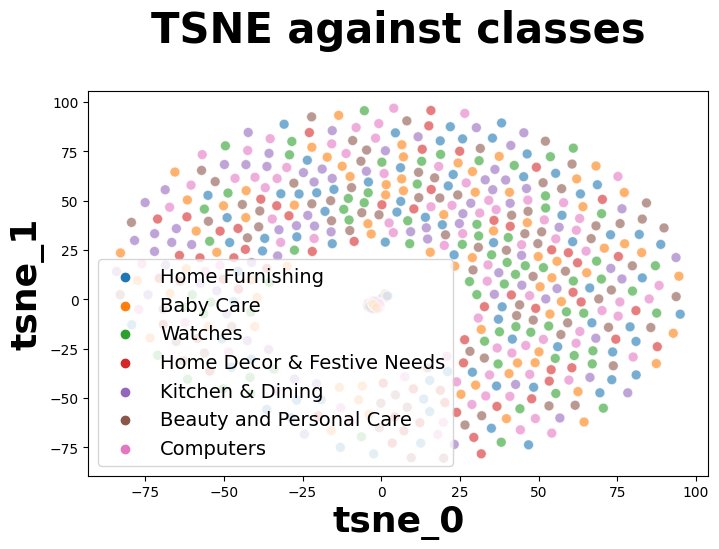

In [3]:
from marketplace_commons import get_class_names
from img_ml import show_tsne
show_tsne(tsne_feats, get_class_names(), "classes")

### Analyse mesures : similarité entre catégories et clusters

####  Création de clusters à partir du T-SNE

In [4]:
"""from sklearn import cluster
cls = cluster.KMeans(n_clusters=7, n_init="auto", random_state=42)
cls.fit(tsne_feats)
clu_labels = cls.labels_"""
from img_ml import get_tsne_km_clusters
clu_labels = get_tsne_km_clusters()

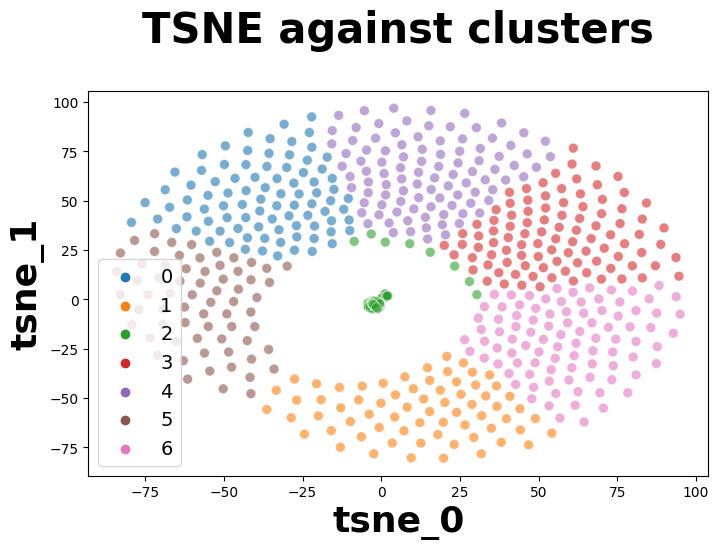

In [6]:
from img_ml import show_tsne
show_tsne(tsne_feats, clu_labels, "clusters")

####  Affichage des images selon les clusters et calcul ARI de similarité catégories images / clusters
* Le score ARI de 0.15 reste faible

#### Analyse par classes
* La matrice de confusion doit être transformée pour mettre avoir en colonne le même ordre des catégories supposées qu'en ligne
* Cette transformation atteint ses limites pour les 2 catégories "shine" et "sunshine" qui sont peu séparées (donc elle a été réalisée manuellement au lieu d'utiliser la fonction "argmax")

In [7]:
from marketplace_commons import get_class_labels
cla_labels = get_class_labels()

In [76]:
data.groupby("clu_label").count()["cla_label"]

clu_label
0     88
1     68
2    540
3     97
4     98
5     66
6     93
Name: cla_label, dtype: int64

In [77]:
from sklearn import metrics
conf_mat = metrics.confusion_matrix(cla_labels, clu_labels)
print(conf_mat)

[[17  5 69 21 14  8 16]
 [18 10 74 13  9 10 16]
 [10 11 79 13 18  6 13]
 [12 13 78 11 12 13 11]
 [13 12 74 17 16  8 10]
 [11 12 81 10 16 14  6]
 [ 7  5 85 12 13  7 21]]


In [80]:
import numpy as np
display(len(cla_labels))
display(np.unique(cla_labels))
display(len(clu_labels))
display(np.unique(clu_labels))

1050

array([0, 1, 2, 3, 4, 5, 6], dtype=int8)

1050

array([0, 1, 2, 3, 4, 5, 6])

In [81]:
def conf_mat_transform(y_true, y_pred) :
    conf_mat = metrics.confusion_matrix(y_true, y_pred)
    corresp = np.argmax(conf_mat, axis=0)
    display(corresp)
    # corresp = [3, 1, 2, 0]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(cla_labels, clu_labels)
conf_mat = metrics.confusion_matrix(cla_labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(cla_labels, cls_labels_transform))

array([1, 3, 6, 0, 2, 5, 6], dtype=int64)

Correspondance des clusters :  [1 3 6 0 2 5 6]
[[ 21  17  14   5   0   8  85]
 [ 13  18   9  10   0  10  90]
 [ 13  10  18  11   0   6  92]
 [ 11  12  12  13   0  13  89]
 [ 17  13  16  12   0   8  84]
 [ 10  11  16  12   0  14  87]
 [ 12   7  13   5   0   7 106]]

              precision    recall  f1-score   support

           0       0.22      0.14      0.17       150
           1       0.20      0.12      0.15       150
           2       0.18      0.12      0.15       150
           3       0.19      0.09      0.12       150
           4       0.00      0.00      0.00       150
           5       0.21      0.09      0.13       150
           6       0.17      0.71      0.27       150

    accuracy                           0.18      1050
   macro avg       0.17      0.18      0.14      1050
weighted avg       0.17      0.18      0.14      1050



C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344

In [8]:
from marketplace_commons import get_class_labels, get_class_names, get_class_label_name_map
# get_class_labels()
# get_class_names()

# TODO : résolution du problème d'alignement classes / clusters cf. projet précédent
# le gars du séminaire ne l'a pas résolu puisqu'il a défini le mappage en manuel
cla_dict = get_class_label_name_map()
display(cla_dict)

{0: 'Baby Care',
 1: 'Beauty and Personal Care',
 2: 'Computers',
 3: 'Home Decor & Festive Needs',
 4: 'Home Furnishing',
 5: 'Kitchen & Dining',
 6: 'Watches'}

In [93]:
"""labels = get_class_labels_v2()
display(dict(enumerate(labels.level_0.cat.categories)))
display(labels.level_0.cat.categories)"""

{0: 'Baby Care',
 1: 'Beauty and Personal Care',
 2: 'Computers',
 3: 'Home Decor & Festive Needs',
 4: 'Home Furnishing',
 5: 'Kitchen & Dining',
 6: 'Watches'}

Index(['Baby Care', 'Beauty and Personal Care', 'Computers',
       'Home Decor & Festive Needs', 'Home Furnishing', 'Kitchen & Dining',
       'Watches'],
      dtype='object')

<AxesSubplot:>

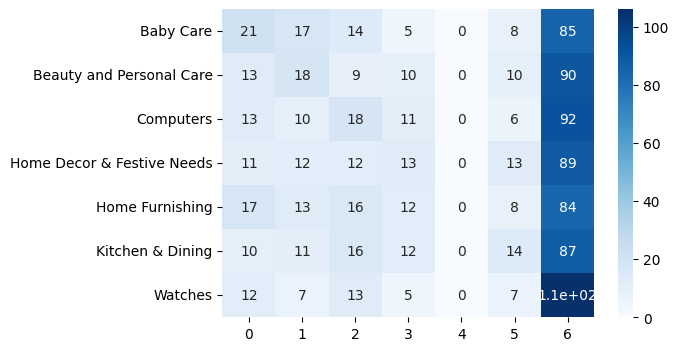

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
data_cm = pd.DataFrame(
    conf_mat,
    index=cla_dict.values(),  # labels.level_0.cat.categories,
    columns=[str(i) for i in range(7)]
)
plt.figure(figsize=(6, 4))
sns.heatmap(data_cm, annot=True, cmap="Blues")
plt.show()

# Annexe K : estimation du nombre de clusters de descripteurs

Dans cette annexe, nous abordons une question laissée en suspens par le séminaire d'Open Classrooms qui donne une introduction à ce qui a été réalisé dans cette partie du 6ème projet.

Le projet précédent a été l'occasion d'expérimenter différentes méthodes pour identifier objectivement le $k$ optimal pour un $k$-Means.

Or, dans le séminaire, l'enseignant nous renvoie à une heuristiques empirique consistant à prendre $k = \sqrt{n}$ où $n$ est la population de l'échantillon.

Nous avons souhaité vérifier cette assomption en utilisant la méthode du coude de variance, et l'indice de Davis-Bouldin.

## Selon le séminaire OC

In [ ]:
import numpy as np
k = int(round(np.sqrt(data.shape[0]), 0))
print("Nombre de clusters estimés : ", k)

Nombre de clusters estimés :  125


## Inertia

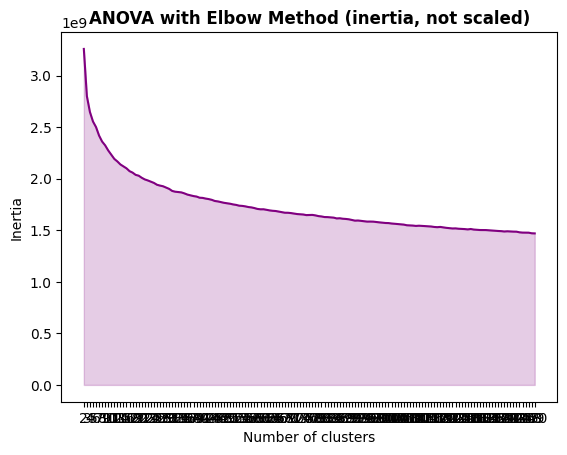

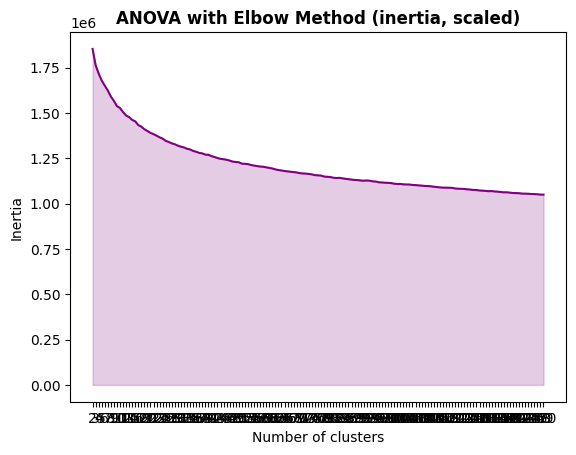

In [ ]:
from img_ml import select_k_with_anova

select_k_with_anova(data, k_min=2, k_max=150)
select_k_with_anova(data, k_min=2, k_max=150, normalize=True)

## Silhouette

In [ ]:
from img_ml import select_k_with_anova
select_k_with_anova(descs, k_min=2, k_max=150, metric='silhouette', color='green')
select_k_with_anova(descs, k_min=2, k_max=150, metric='silhouette', color='green', normalize=True)

## Davis-Bouldin

Rapide étude de complexité algorithmique :
* pour un `k_max` à 10, c'est 5s
* pour un `k_max` à 100, c'est 60s
* pour un `k_max` à 300, c'est 6min10s

Posons $N$ pour représenter `k_max` et $s$ pour représenter `k_step`, et $\displaystyle K = \frac{N}{s}$.

Le $k$-Means a une complexité $\mathcal{O}{(knT)}$ où $n$ est le nombre d'échantillons et $T$ le nombre d'itérations.

Ici, $n$ et $T$ sont fixes, et tout dépend de $k$.

La complexité est $\displaystyle \mathcal{O} = \sum_{k=0}^{K-1}{knT} = (2K + \frac{1}{2}K(K+1))nT
\approx \frac{1}{2}K^2nT$

Si $K=10$ prend une dizaine de secondes, $\displaystyle K=600=\frac{3000}{5}$, prendra $10.600^2=360000$ secondes, donc $1000$ heures.

Pour chercher le meilleur $k$ avec Davis-Bouldin comme avec les méthodes à coude de variance, il faut augmenter le pas, pour embrasser un intervalle de $k$ plus large, sous hypothèse de continuité, puis raffiner une fois qu'un premier intervalle de valeurs intéressantes est trouvé.

Nous maintenons donc un $K$ constant de 100 et démarrons sur l'intervalle de $k$ compris entre $0$ et $n$, ce qui détermine un pas $\displaystyle s = \frac{N}{K}$ qui s'établit à $155$ sur le cas `sample_8`.



c:\Users\franc\Projects\pepper_automatic_product_classification_engine\notebooks\img_ml.py:162: ConvergenceWarning: Number of distinct clusters (15468) found smaller than n_clusters (15502). Possibly due to duplicate points in X.
  kmeans.fit(crfm)


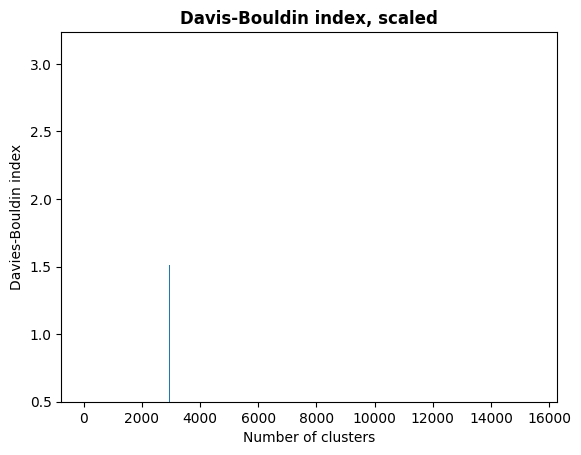

best k's: [15502, 15347, 15192, 15037, 14882, 14727, 14572, 14417, 14262, 14107]
scores: [0.0, 0.05, 0.08, 0.11, 0.12, 0.14, 0.15, 0.17, 0.19, 0.2]
times: [612.02, 122.85, 90.12, 91.77, 83.04, 73.76, 72.5, 81.85, 100.33, 76.94]


In [ ]:
from img_ml import select_k_with_davies_bouldin
k_min, k_max, k_step = 2, 15_547, 155
scores, best_ks, dts = select_k_with_davies_bouldin(
    descs, normalize=True, k_min=k_min, k_max=k_max, k_step=k_step
)
print("best k's:", best_ks[:10])
print("scores:", [round(scores[(i-k_min)//k_step], 2) for i in best_ks[:10]])
print("times:", [round(dts[(i-k_min)//k_step], 2) for i in best_ks[:10]])

Conclusion : il n'y a pas vraiment de coude.

Donc le $k$ idéal est le $n$ ce qui n'a pas d'intérêt puisque chauque élement représente une classe singleton.

La racine est une façon de définir $p$ classes de $p$ éléments. C'est un compromis arbitraire entre nombre de classes et taille des classes.

Partons donc là dessus en espérant avoir plus tard une meilleure justification de ce choix empirique.